# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**


## 1. Preparación del Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

In [3]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

In [4]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [5]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  hora_fin    dia estacion sentido  \
0     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
1     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
2     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
3     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
4     2018  2018-01-01            2         3  Lunes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              29  
1       Liviano    TELEPASE               9  
2       Liviano  NO COBRADO              73  
3       Liviano    TELEPASE              39  
4       Liviano  NO COBRADO             115

In [6]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [7]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [8]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [9]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [10]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [11]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [12]:
dataset.dtypes

fecha             object
hora_fin           int64
dia               object
sentido           object
tipo_vehiculo     object
cantidad_pasos     int64
dtype: object

In [13]:
dataset.isna().sum()

fecha             0
hora_fin          0
dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
dtype: int64

In [14]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos              fecha2
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [15]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [16]:
dataset.dtypes

dia                       object
sentido                   object
tipo_vehiculo             object
cantidad_pasos             int64
fecha             datetime64[ns]
dtype: object

In [17]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
...         ...        ...           ...             ...                 ...
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[238869 rows x 5 columns]

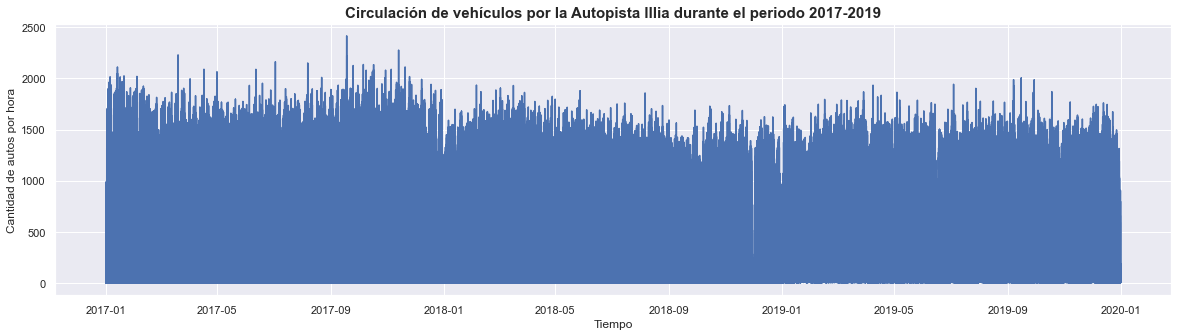

In [18]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (20,5))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos por hora')
plt.title('Circulación de vehículos por la Autopista Illia durante el periodo 2017-2019', fontsize=15, fontweight='bold', fontstretch='normal')
plt.show()

In [19]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486

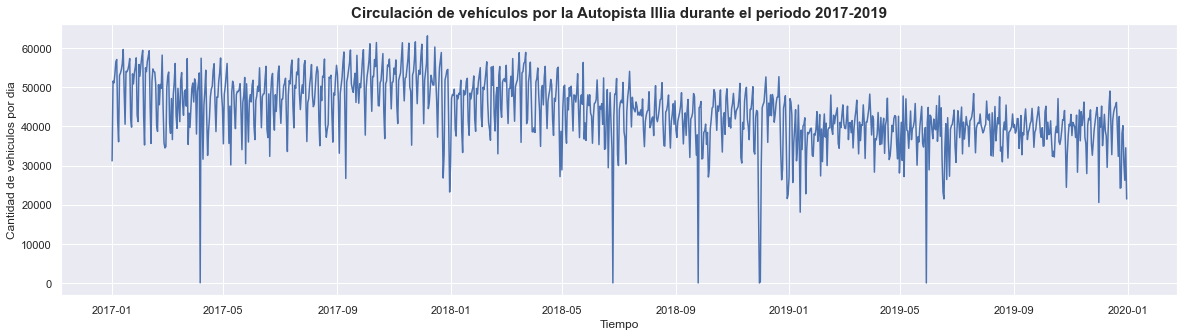

In [20]:
plt.figure(figsize = (20,5))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehiculos por dia')
plt.title('Circulación de vehículos por la Autopista Illia durante el periodo 2017-2019', fontsize=15, fontweight='bold', fontstretch='normal')
plt.show()

## PARTE A - Exploración de datos

### 1. Análisis de Valores Faltantes

#### 1.1 Búsqueda de valores faltantes

Para conocer mejor el dataset procesado a partir de los 3 datasets de flujo vehicular en los años 2017, 2018 y 2019, se realizará un estudio del contenido del dataset. Conociendo qué significa cada dato según lo analizado en instancias anteriores, se pretende investigar sobre la existencia de valores faltantes. Puede suceder que exista una fecha sin su valor de cantidad de pasos de vehículos, o vicerversa. También puede ocurrir que no estén ni la fecha ni la cantidad de pasos de vehículos, es decir, ninguno de los 2 datos.

In [21]:
diario.isna().sum()

cantidad_pasos    0
dtype: int64

En este primer análisis, no se observan valores faltantes de "cantidad_pasos". Por lo tanto, se tienen todos los datos de los vehículos que pasaron por el peaje de la Autopista Illia y que pagaron en efectivo.

In [22]:
diario["fecha"] = diario.index
diario['date_check'] = diario.fecha.diff()
diario.date_check.value_counts()

1 days    1094
Name: date_check, dtype: int64

In [23]:
diario

cantidad_pasos      fecha date_check
fecha                                           
2017-01-01           31183 2017-01-01        NaT
2017-01-02           51568 2017-01-02     1 days
2017-01-03           51093 2017-01-03     1 days
2017-01-04           53332 2017-01-04     1 days
2017-01-05           56486 2017-01-05     1 days
...                    ...        ...        ...
2019-12-27           40182 2019-12-27     1 days
2019-12-28           30681 2019-12-28     1 days
2019-12-29           26259 2019-12-29     1 days
2019-12-30           34523 2019-12-30     1 days
2019-12-31           21447 2019-12-31     1 days

[1095 rows x 3 columns]

Luego, revisando la diferencia temporal entre los valores de fecha se observa que se respeta la diferencia de 1 día. Esto significa que no hay fechas faltantes.

In [24]:
diario.drop(["fecha","date_check"], axis=1, inplace=True)

In [25]:
diario

cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486
...                    ...
2019-12-27           40182
2019-12-28           30681
2019-12-29           26259
2019-12-30           34523
2019-12-31           21447

[1095 rows x 1 columns]

En conclusión, **no hay valores faltantes de fecha ni de cantidad de vehiculos que pasaron por la Autopista Illia**.

#### 1.2 Análisis de Anomalías

El análisis de anomalías consiste en detectar valores atípicos dentro de la serie de tiempo. Para comenzar este estudio se observa el gráfico anterior en el cual se muestra la cantidad de autos que pasan por día. 

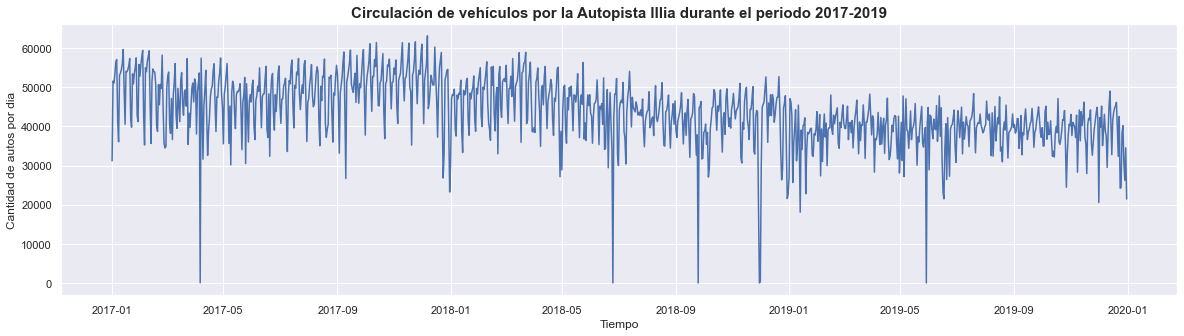

In [26]:
plt.figure(figsize = (20,5))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos por dia')
plt.title('Circulación de vehículos por la Autopista Illia durante el periodo 2017-2019', fontsize=15, fontweight='bold', fontstretch='normal')
plt.show()

**Se observa que existen eventos anómalos**. En general, se tratan de días en los cuales pasaron menos de 10000 vehículos o prácticamente la cantidad de vehículos fue nula. Estos días son los siguientes.

In [27]:
diario.cantidad_pasos[diario.cantidad_pasos<=10000]

fecha
2017-04-06     40
2018-06-25      0
2018-09-25      0
2018-11-30      0
2018-12-01    350
2019-05-29      0
Name: cantidad_pasos, dtype: int64

De esta manera, sabemos que el 06/04/2017 circularon apenas 40 vehículos por la autopista Illia. Mientras que durante el 2018 hubo 3 dias en donde no circularon vehículos y un día con apenas 350 pasos de vehículos. Durante el 2019 hubo un solo día sin paso de vehículos, el 29/05/2019. Para entender esto se investigan los sucesos durante estas fechas para entender mejor la situación.

En estas fecha ocurrieron eventos extraordinarios que no son habituales. EN general se trataron de eventos gremiales y encuentros internacionales que requieron el corte de accesos hacia la Ciudad de Buenos Aires.

*  2017-04-06: [Paro general de la CGT](https://www.pagina12.com.ar/30044-una-muestra-de-rechazo-al-ajuste-pro)
*  2018-06-25: [Paro general de la CGT](https://www.infobae.com/diarios/2018/06/25/clarin-lunes-25-de-junio-de-2018/)
*  2018-09-25: [Paro general de la CGT](https://www.clarin.com/viajes/paro-general-25-septiembre-operan-aeropuertos_0_0KqpCPX5B.html)
*  2018-11-30: [Comienzo G20 en Argentina](https://www.infobae.com/america/portadas/2018/11/30/clarin-argentina-viernes-30-de-noviembre-de-2018/)
*  2018-12-01: [Continúa G20 en Argentina](https://www.infobae.com/america/portadas/2018/12/01/clarin-argentina-sabado-1-de-diciembre-de-2018/)
*  2019-05-29: [Paro general de la CGT](https://www.perfil.com/noticias/politica/como-se-vive-paro-miercoles-29-de-mayo-en-las-redes-sociales.phtml)

Dado que estas anomalías pueden alterar los resultados de los modelos de predicción a futuro, **se decide eliminarlas para suavizar la serie de tiempo**. Para hacer esto se consideran los paso de vehículos menores a 10000 como valores NaN. Esto se trata más adelante.

#### 1.3 Imputación de valores faltantes

In [28]:
diario.cantidad_pasos[diario.cantidad_pasos <= 10000] = np.nan
diario.isna().sum()

cantidad_pasos    6
dtype: int64

Se interpola la serie para imputar los valores faltantes surgidos a partir de la eliminación de los eventos anómalos.

In [29]:
print(diario.isna().sum())
diario = diario.interpolate()
print(diario.isna().sum())

cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


Se vuelve a graficar la serie de tiempo para ver la nueva forma de los datos.

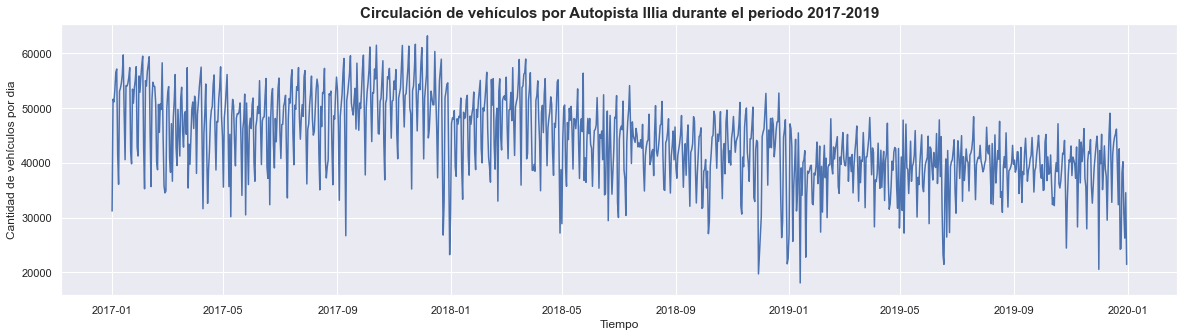

In [30]:
plt.figure(figsize = (20,5))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por dia')
plt.title('Circulación de vehículos por Autopista Illia durante el periodo 2017-2019', fontsize=15, fontweight='bold', fontstretch='normal')
plt.show()

### 2. Información de Interés

En este apartado se van a plantear algunas particularidades sobre el dataset, que responden algunas preguntas que uno se puede hacer respecto de la información representada en el gráfico anterior.

#### 2.1 Fecha de la mayor cantidad de pasos de vehículos por Au. Illia

Por empezar, si nos preguntamos cuándo fue la fecha que se produjo la mayor cantidad de pasos por la Autopista Illia, se obtiene la siguiente información.

In [31]:
diario.cantidad_pasos[diario.cantidad_pasos==diario.cantidad_pasos.max()]

fecha
2017-12-07    63127.0
Freq: D, Name: cantidad_pasos, dtype: float64

Observando el gráfico **"Circulación de vehículos por la Autopista Illia durante el periodo 2017-2019"** y analizando los datos de todo el dataset, se encuentra que **la mayor cantidad de vehículos se produjo el 07/12/2017 con una cantidad de 63127 vehículos**.

Analizando más sobre esa fecha, se obtiene lo siguiente.

In [32]:
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
...         ...        ...           ...             ...                 ...
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[238869 rows x 5 columns]

In [33]:
dataset.loc[97417]

dia                            Jueves
sentido                        Centro
tipo_vehiculo                  Pesado
cantidad_pasos                      2
fecha             2017-12-07 00:00:00
Name: 97417, dtype: object

In [34]:
dataset.shape

(238869, 5)

In [35]:
dataset.cantidad_pasos.sum()

47865581

In [36]:
mask = (dataset['fecha'] >= '2017-12-07 00:00:00') & (dataset['fecha'] <= '2017-12-07 23:59:59')
mayor_circulacion = dataset.loc[mask]
mayor_circulacion

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
97406  Jueves     Centro        Pesado              15 2017-12-07 00:00:00
97407  Jueves     Centro        Pesado               2 2017-12-07 00:00:00
97408  Jueves     Centro        Pesado               1 2017-12-07 00:00:00
97409  Jueves     Centro        Pesado               6 2017-12-07 00:00:00
97410  Jueves  Provincia        Pesado              12 2017-12-07 00:00:00
...       ...        ...           ...             ...                 ...
97702  Jueves     Centro       Liviano             957 2017-12-07 23:00:00
97703  Jueves     Centro        Pesado              18 2017-12-07 23:00:00
97704  Jueves  Provincia       Liviano              59 2017-12-07 23:00:00
97705  Jueves  Provincia       Liviano             981 2017-12-07 23:00:00
97706  Jueves     Centro       Liviano              40 2017-12-07 23:00:00

[301 rows x 5 columns]

In [37]:
mayor_circulacion.cantidad_pasos.sum()

63127

In [38]:
tipo_vehiculo = mayor_circulacion["tipo_vehiculo"].value_counts() 
tipo_vehiculo

Pesado     204
Liviano     97
Name: tipo_vehiculo, dtype: int64

In [39]:
sentido = mayor_circulacion["sentido"].value_counts()
sentido

Centro       157
Provincia    144
Name: sentido, dtype: int64

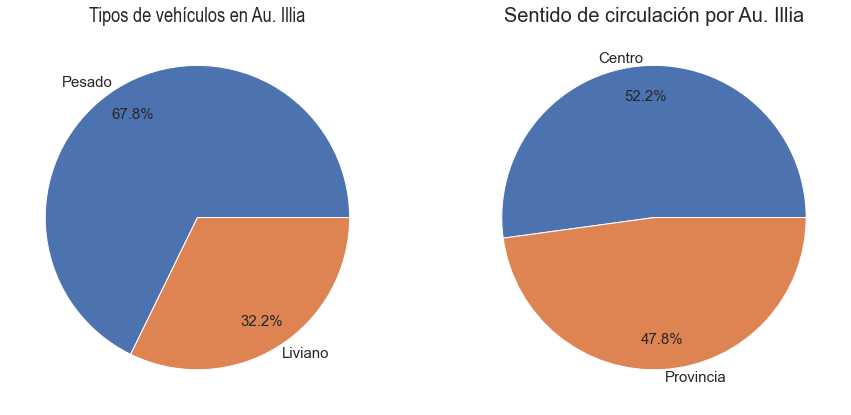

In [40]:
tipo_vehiculo = mayor_circulacion["tipo_vehiculo"].value_counts() 
sentido = mayor_circulacion["sentido"].value_counts() 

#fig1, ax1 = plt.subplots(1,2, figsize=(8,8))

plt.figure(figsize = (15,40))

plt.subplot(1,2,1)
plt.pie(x = tipo_vehiculo,labels = tipo_vehiculo.index,
        autopct = '%1.1f%%',textprops = {'fontsize': 15},
        pctdistance = 0.8,labeldistance = 1.05)
plt.title("Tipos de vehículos en Au. Illia", size=20, stretch=50)

plt.subplot(1,2,2)
plt.pie(x = sentido,labels = sentido.index,
        autopct = '%1.1f%%',textprops = {'fontsize': 15},
        pctdistance = 0.8,labeldistance = 1.05)
plt.title("Sentido de circulación por Au. Illia", size=20)
plt.show()

In [41]:
sentido_centro = mayor_circulacion[mayor_circulacion.sentido=='Centro']
sentido_centro

dia sentido tipo_vehiculo  cantidad_pasos               fecha
97406  Jueves  Centro        Pesado              15 2017-12-07 00:00:00
97407  Jueves  Centro        Pesado               2 2017-12-07 00:00:00
97408  Jueves  Centro        Pesado               1 2017-12-07 00:00:00
97409  Jueves  Centro        Pesado               6 2017-12-07 00:00:00
97414  Jueves  Centro       Liviano             674 2017-12-07 00:00:00
...       ...     ...           ...             ...                 ...
97699  Jueves  Centro        Pesado               2 2017-12-07 23:00:00
97701  Jueves  Centro        Pesado               1 2017-12-07 23:00:00
97702  Jueves  Centro       Liviano             957 2017-12-07 23:00:00
97703  Jueves  Centro        Pesado              18 2017-12-07 23:00:00
97706  Jueves  Centro       Liviano              40 2017-12-07 23:00:00

[157 rows x 5 columns]

In [42]:
vehiculo_centro = (sentido_centro["tipo_vehiculo"].value_counts()*100)/len(sentido_centro)
vehiculo_centro

Pesado     68.789809
Liviano    31.210191
Name: tipo_vehiculo, dtype: float64

De los 63147 vehiculos que pasaron por la Autopista Illia, el 67,8 % fueron vehículos pesados. Por otro lado, el 52,2 % se dirigían mano hacia el centro, del cual el 68,78 % se trata de vehículos pesados. Sorprende que la tendencia de los vehículos que más ingresan a la Ciudad de Buenos Aires sean los llamados "pesados", pudiendo ser estos vehículos con carga mayor a 4 Tn o buses de transporte de pasajeros. La cercanía al puerto de la ciudad como a la terminal de omnibus puede ser una justificación de este hecho.

#### 2.2 Día y horario de mayor circulación

In [43]:
dataset['Horario'],dataset['solo_fecha']= dataset['fecha'].apply(lambda x:x.time()), dataset['fecha'].apply(lambda x:x.date())
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha  \
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00   
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00   
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00   
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00   
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00   
...         ...        ...           ...             ...                 ...   
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00   
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00   
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00   
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00   
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00   

         Horario  solo_fecha  
0       00:00:00  2017-01-01  
1       00:00:00  2017-01-01  
2       00:00:00  2017-01-01  
3       00:00:00  2017-01-01  
4       00:00:00  2017-01-01  
...          ...         ...  
238864  22:00:00  2019-12-31  
238865  22:00:00  2019-12-31  
238866  22:00:00  2019-12-31  
238867  23:00:00  2019-12-31  
238868  23:00:00  2019-12-31  

[238869 rows x 7 columns]

In [44]:
dataset.dtypes

dia                       object
sentido                   object
tipo_vehiculo             object
cantidad_pasos             int64
fecha             datetime64[ns]
Horario                   object
solo_fecha                object
dtype: object

In [45]:
mask_domingo=dataset["dia"]=='Domingo'
mask_lunes=dataset["dia"]=='Lunes'
mask_martes=dataset["dia"]=='Martes'
mask_miercoles=dataset["dia"]=='Miércoles'
mask_jueves=dataset["dia"]=='Jueves'
mask_viernes=dataset["dia"]=='Viernes'
mask_sabado=dataset["dia"]=='Sábado'

data_domingo_diario = dataset[mask_domingo].groupby(by="solo_fecha").sum()
data_domingo_diario.index=pd.to_datetime(data_domingo_diario.index)
data_domingo_mensual=data_domingo_diario.resample("M").mean()

In [46]:
data_domingo_diario

cantidad_pasos
solo_fecha                
2017-01-01           31183
2017-01-08           36065
2017-01-15           40546
2017-01-22           39804
2017-01-29           41218
...                    ...
2019-12-01           20553
2019-12-08           38839
2019-12-15           32774
2019-12-22           32337
2019-12-29           26259

[157 rows x 1 columns]

In [47]:
data_domingo_mensual

cantidad_pasos
solo_fecha                
2017-01-31        37763.20
2017-02-28        36338.25
2017-03-31        40072.00
2017-04-30        39093.00
2017-05-31        36279.50
2017-06-30        38115.50
2017-07-31        38875.80
2017-08-31        38318.50
2017-09-30        38831.25
2017-10-31        41656.40
2017-11-30        45491.00
2017-12-31        37358.20
2018-01-31        36825.25
2018-02-28        40509.75
2018-03-31        39904.00
2018-04-30        35775.40
2018-05-31        37021.50
2018-06-30        34916.25
2018-07-31        36919.80
2018-08-31        37780.25
2018-09-30        33851.40
2018-10-31        36561.25
2018-11-30        36351.25
2018-12-31        32434.40
2019-01-31        29985.25
2019-02-28        39051.50
2019-03-31        36697.80
2019-04-30        35993.75
2019-05-31        33973.25
2019-06-30        33885.80
2019-07-31        35141.00
2019-08-31        38321.25
2019-09-30        38574.40
2019-10-31        32541.25
2019-11-30        38370.00
2019-12-31        30152.40

In [48]:
data_lunes_diario = dataset[mask_lunes].groupby(by="solo_fecha").sum()
data_lunes_diario.index=pd.to_datetime(data_lunes_diario.index)
data_lunes_mensual=data_lunes_diario.resample("M").mean()

data_martes_diario = dataset[mask_martes].groupby(by="solo_fecha").sum()
data_martes_diario.index=pd.to_datetime(data_martes_diario.index)
data_martes_mensual=data_martes_diario.resample("M").mean()

data_miercoles_diario = dataset[mask_miercoles].groupby(by="solo_fecha").sum()
data_miercoles_diario.index=pd.to_datetime(data_miercoles_diario.index)
data_miercoles_mensual=data_miercoles_diario.resample("M").mean()

data_jueves_diario = dataset[mask_jueves].groupby(by="solo_fecha").sum()
data_jueves_diario.index=pd.to_datetime(data_jueves_diario.index)
data_jueves_mensual=data_jueves_diario.resample("M").mean()

data_viernes_diario = dataset[mask_viernes].groupby(by="solo_fecha").sum()
data_viernes_diario.index=pd.to_datetime(data_viernes_diario.index)
data_viernes_mensual=data_viernes_diario.resample("M").mean()

data_sabado_diario = dataset[mask_sabado].groupby(by="solo_fecha").sum()
data_sabado_diario.index=pd.to_datetime(data_sabado_diario.index)
data_sabado_mensual=data_sabado_diario.resample("M").mean()

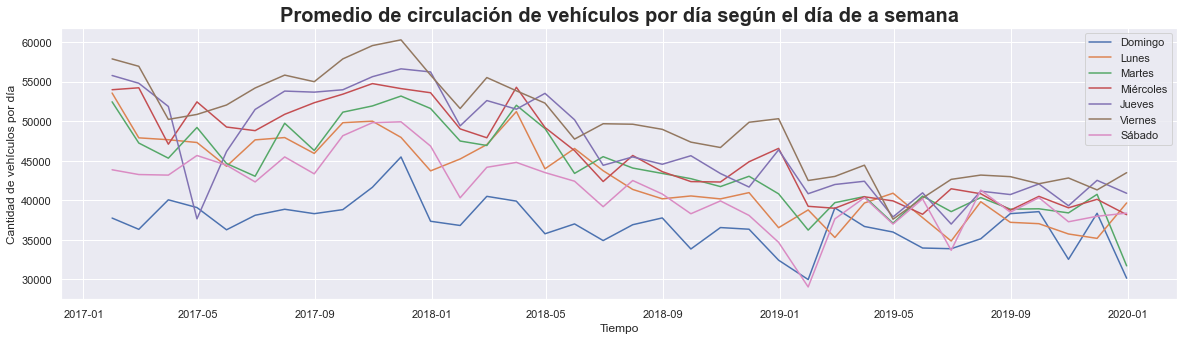

In [49]:
plt.figure(figsize = (20,5))
plt.plot(data_domingo_mensual.index, data_domingo_mensual.cantidad_pasos, label = 'Domingo')
plt.plot(data_lunes_mensual.index, data_lunes_mensual.cantidad_pasos, label = 'Lunes')
plt.plot(data_martes_mensual.index, data_martes_mensual.cantidad_pasos, label = 'Martes')
plt.plot(data_miercoles_mensual.index, data_miercoles_mensual.cantidad_pasos, label = 'Miércoles')
plt.plot(data_jueves_mensual.index, data_jueves_mensual.cantidad_pasos, label = 'Jueves')
plt.plot(data_viernes_mensual.index, data_viernes_mensual.cantidad_pasos, label = 'Viernes')
plt.plot(data_sabado_mensual.index, data_sabado_mensual.cantidad_pasos, label = 'Sábado')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.legend()
plt.title("Promedio de circulación de vehículos por día según el día de a semana",fontsize=20, fontweight='bold', fontstretch='normal')
plt.show()

In [50]:
print(f'Cantidad promedio de vehículos durante los domingos: {data_domingo_mensual.mean()}')
print("Cantidad promedio de vehículos durante los lunes:", data_lunes_mensual.mean())
print("Cantidad promedio de vehículos durante los martes:", data_martes_mensual.mean())
print("Cantidad promedio de vehículos durante los miercoles:", data_miercoles_mensual.mean())
print("Cantidad promedio de vehículos durante los jueves:", data_jueves_mensual.mean())
print("Cantidad promedio de vehículos durante los viernes:", data_viernes_mensual.mean())
print("Cantidad promedio de vehículos durante los sabados:", data_sabado_mensual.mean())

Cantidad promedio de vehículos durante los domingos: cantidad_pasos    36936.965278
dtype: float64
Cantidad promedio de vehículos durante los lunes: cantidad_pasos    42878.287963
dtype: float64
Cantidad promedio de vehículos durante los martes: cantidad_pasos    44113.323148
dtype: float64
Cantidad promedio de vehículos durante los miercoles: cantidad_pasos    45987.615278
dtype: float64
Cantidad promedio de vehículos durante los jueves: cantidad_pasos    46796.029167
dtype: float64
Cantidad promedio de vehículos durante los viernes: cantidad_pasos    49357.461111
dtype: float64
Cantidad promedio de vehículos durante los sabados: cantidad_pasos    41305.322222
dtype: float64


De este gráfico se destaca que la mayor circulación por la autopista Illia se produce los días **viernes**. Paara detectar esto se consideraron los valores promedios de circulación a partir de la variación de la circulación de vehiculos en un día determinado. Se recuerda que solamente se considera la modalidad de pago en efectivo.

Para determinar el horario de mayor ciruclación se realiza lo siguiente:

In [51]:
dataset["año"] = dataset['fecha'].dt.year
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha  \
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00   
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00   
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00   
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00   
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00   
...         ...        ...           ...             ...                 ...   
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00   
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00   
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00   
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00   
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00   

         Horario  solo_fecha   año  
0       00:00:00  2017-01-01  2017  
1       00:00:00  2017-01-01  2017  
2       00:00:00  2017-01-01  2017  
3       00:00:00  2017-01-01  2017  
4       00:00:00  2017-01-01  2017  
...          ...         ...   ...  
238864  22:00:00  2019-12-31  2019  
238865  22:00:00  2019-12-31  2019  
238866  22:00:00  2019-12-31  2019  
238867  23:00:00  2019-12-31  2019  
238868  23:00:00  2019-12-31  2019  

[238869 rows x 8 columns]

In [52]:
dataset_2017 = dataset[dataset.año == 2017]
dataset_2017

dia    sentido tipo_vehiculo  cantidad_pasos               fecha  \
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00   
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00   
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00   
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00   
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00   
...         ...        ...           ...             ...                 ...   
104225  Domingo  Provincia       Liviano               8 2017-12-31 23:00:00   
104226  Domingo     Centro        Pesado               1 2017-12-31 23:00:00   
104227  Domingo     Centro        Pesado               1 2017-12-31 23:00:00   
104228  Domingo     Centro       Liviano             151 2017-12-31 23:00:00   
104229  Domingo     Centro       Liviano               8 2017-12-31 23:00:00   

         Horario  solo_fecha   año  
0       00:00:00  2017-01-01  2017  
1       00:00:00  2017-01-01  2017  
2       00:00:00  2017-01-01  2017  
3       00:00:00  2017-01-01  2017  
4       00:00:00  2017-01-01  2017  
...          ...         ...   ...  
104225  23:00:00  2017-12-31  2017  
104226  23:00:00  2017-12-31  2017  
104227  23:00:00  2017-12-31  2017  
104228  23:00:00  2017-12-31  2017  
104229  23:00:00  2017-12-31  2017  

[104230 rows x 8 columns]

In [53]:
dataset_2018 = dataset[dataset.año == 2018]
dataset_2019 = dataset[dataset.año == 2019]

In [54]:
dataset_2017 = dataset_2017.groupby(by = "fecha").sum()
dataset_2017["hora"] = dataset_2017.index.hour
dataset_2017 = dataset_2017.drop(columns = ["año"])
dataset_2017

cantidad_pasos  hora
fecha                                    
2017-01-01 00:00:00            1576     0
2017-01-01 01:00:00               1     1
2017-01-01 02:00:00            1374     2
2017-01-01 03:00:00            1734     3
2017-01-01 04:00:00            1247     4
...                             ...   ...
2017-12-31 19:00:00            1560    19
2017-12-31 20:00:00            1617    20
2017-12-31 21:00:00            1896    21
2017-12-31 22:00:00            1244    22
2017-12-31 23:00:00             319    23

[8723 rows x 2 columns]

In [55]:
dataset_2017 = dataset_2017.groupby(by = "hora").mean().round(0)
dataset_2017

cantidad_pasos
hora                
0             1058.0
1              875.0
2              617.0
3              424.0
4              328.0
5              398.0
6              767.0
7             1578.0
8             2437.0
9             2643.0
10            2591.0
11            2623.0
12            2782.0
13            2945.0
14            3033.0
15            2962.0
16            2998.0
17            3048.0
18            3188.0
19            3164.0
20            2713.0
21            2405.0
22            1923.0
23            1431.0

In [56]:
dataset_2018 = dataset_2018.groupby(by = "fecha").sum()
dataset_2018["hora"] = dataset_2018.index.hour
dataset_2018 = dataset_2018.drop(columns = ["año"])
dataset_2018 = dataset_2018.groupby(by = "hora").mean().round(0)
dataset_2018

cantidad_pasos
hora                
0              998.0
1              830.0
2              576.0
3              402.0
4              315.0
5              388.0
6              746.0
7             1486.0
8             2075.0
9             2225.0
10            2239.0
11            2342.0
12            2526.0
13            2687.0
14            2790.0
15            2735.0
16            2755.0
17            2732.0
18            2868.0
19            2820.0
20            2475.0
21            2169.0
22            1747.0
23            1334.0

In [57]:
dataset_2019 = dataset_2019.groupby(by = "fecha").sum()
dataset_2019["hora"] = dataset_2019.index.hour
dataset_2019 = dataset_2019.drop(columns = ["año"])
dataset_2019 = dataset_2019.groupby(by = "hora").mean().round(0)
dataset_2019

cantidad_pasos
hora                
0              867.0
1              730.0
2              505.0
3              359.0
4              280.0
5              348.0
6              643.0
7             1249.0
8             1773.0
9             1961.0
10            1986.0
11            2068.0
12            2219.0
13            2388.0
14            2465.0
15            2392.0
16            2437.0
17            2467.0
18            2525.0
19            2477.0
20            2145.0
21            1872.0
22            1511.0
23            1138.0

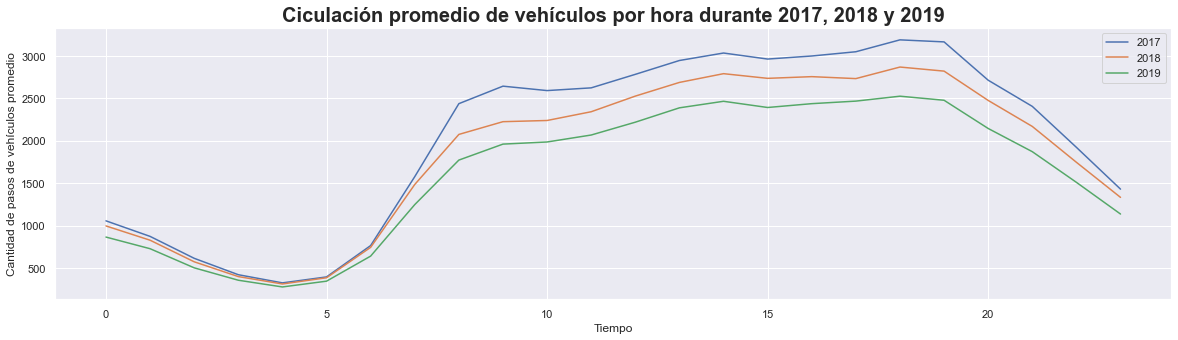

In [58]:
plt.figure(figsize = (20,5))
plt.plot(dataset_2017.index, dataset_2017.cantidad_pasos, label = '2017')
plt.plot(dataset_2018.index, dataset_2018.cantidad_pasos, label = '2018')
plt.plot(dataset_2019.index, dataset_2019.cantidad_pasos, label = '2019')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos de vehículos promedio')
plt.legend()
plt.title("Ciculación promedio de vehículos por hora durante 2017, 2018 y 2019",fontsize=20, fontweight='bold', fontstretch='normal')
plt.show()

Con este gráfico se observa que le horario de mayor circulación de vehículos por la Autopista Illia se da **entre las 17 y las 19 hs**.

In [59]:
dataset_2017.sort_values(by="cantidad_pasos",ascending=False)

cantidad_pasos
hora                
18            3188.0
19            3164.0
17            3048.0
14            3033.0
16            2998.0
15            2962.0
13            2945.0
12            2782.0
20            2713.0
9             2643.0
11            2623.0
10            2591.0
8             2437.0
21            2405.0
22            1923.0
7             1578.0
23            1431.0
0             1058.0
1              875.0
6              767.0
2              617.0
3              424.0
5              398.0
4              328.0

In [60]:
dataset_2018.sort_values(by="cantidad_pasos",ascending=False)

cantidad_pasos
hora                
18            2868.0
19            2820.0
14            2790.0
16            2755.0
15            2735.0
17            2732.0
13            2687.0
12            2526.0
20            2475.0
11            2342.0
10            2239.0
9             2225.0
21            2169.0
8             2075.0
22            1747.0
7             1486.0
23            1334.0
0              998.0
1              830.0
6              746.0
2              576.0
3              402.0
5              388.0
4              315.0

In [61]:
dataset_2019.sort_values(by="cantidad_pasos",ascending=False)

cantidad_pasos
hora                
18            2525.0
19            2477.0
17            2467.0
14            2465.0
16            2437.0
15            2392.0
13            2388.0
12            2219.0
20            2145.0
11            2068.0
10            1986.0
9             1961.0
21            1872.0
8             1773.0
22            1511.0
7             1249.0
23            1138.0
0              867.0
1              730.0
6              643.0
2              505.0
3              359.0
5              348.0
4              280.0

Indagando un poco más, se descubre que **la mayor cantidad de pasos de vehículos se produce durante las 18 hs**.

#### 1.4.3 Vehículos que más transitan por Autopista Illia

In [62]:
diario_liviano = dataset[dataset.tipo_vehiculo == "Liviano"].groupby(by="solo_fecha").sum()
diario_liviano = diario_liviano.drop(columns = "año")
diario_liviano

cantidad_pasos
solo_fecha                
2017-01-01           30641
2017-01-02           48979
2017-01-03           48322
2017-01-04           50581
2017-01-05           53622
...                    ...
2019-12-27           39408
2019-12-28           30245
2019-12-29           25995
2019-12-30           33862
2019-12-31           21221

[1091 rows x 1 columns]

In [63]:
diario_pesado = dataset[dataset.tipo_vehiculo == "Pesado"].groupby(by="solo_fecha").sum()
diario_pesado = diario_pesado.drop(columns = "año")
diario_pesado

cantidad_pasos
solo_fecha                
2017-01-01             542
2017-01-02            2589
2017-01-03            2771
2017-01-04            2751
2017-01-05            2864
...                    ...
2019-12-27             774
2019-12-28             436
2019-12-29             264
2019-12-30             661
2019-12-31             226

[1090 rows x 1 columns]

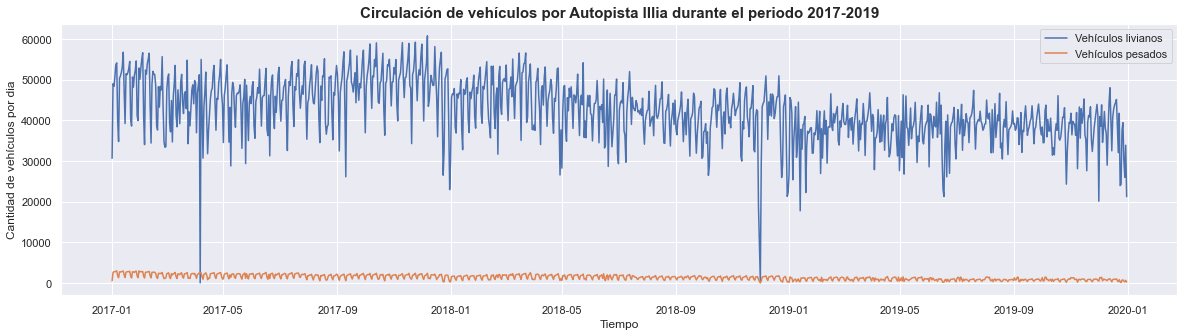

In [64]:
plt.figure(figsize = (20,5))
plt.plot(diario_liviano.index, diario_liviano.cantidad_pasos, label = "Vehículos livianos")
plt.plot(diario_pesado.index, diario_pesado.cantidad_pasos, label = "Vehículos pesados")
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por dia')
plt.title('Circulación de vehículos por Autopista Illia durante el periodo 2017-2019', fontsize=15, fontweight='bold', fontstretch='normal')
plt.legend()
plt.show()

Claramente, **los vehículos livianos circulan más que los vehículos pesados.**

#### 1.5 Autocorrelacion de la serie

Al explorar la serie de tiempo, surge la siguiente pregunta: ¿la cantidad de pasos depende de sí misma en el tiempo? Para realizar esto se realiza un desfasaje de la serie entre un tiempo actual t y un tiempo anterior t-k. De esta forma, se sabrá si la variable cantidad_pasos varía en el mismo sentido que la misma variable un tiempo desfasado, si varía en sentido inverso o si no varía. Esta relación o dependencia de un valor respecto del anterior siempre sería lineal. 

Para estudiar esto existen 2 tipos de autocorrelación:
* FAS: función de autocorrelación simple, que mide la relación lineal entre las observaciones de una serie de datos Y<sub>t</sub> distanciados un lapso de tiempo k conocido como retardo. Este método considera la relación lineal de todos los valores de la serie comparando la variación conjunta de todos los valores de Y<sub>t</sub> en intervalos de tiempo k, con la variación de la secuencia respecto a esos valores. Es decir, Y<sub>t</sub> con Y<sub>t-1</sub>, Y<sub>t-1</sub> con Y<sub>t-2</sub>, e Y<sub>t</sub> con Y<sub>t-2</sub>. 
* FAP: función de autocorrelación parcial. Estima la autocorrelación simple para el mismo retardo k, con la eliminación del efecto producido por las autocorrelaciones para retardos menores a k, las cuales están presentes en la estimación de la autocorrelación simple.


Tanto FAS como FAP, definen un coeficiente de autocorrelación r<sub>k</sub> cada uno. Esto varían entre 1 y -1. Un valor cercano a 1, determina una relación directa entre observaciones. Un coeficiente cercano a -1 expresa una relación inversa entre observaciones. Un valor igual a 0 indica que no hay relación entre 2 valores de una misma serie de tiempo.

Otra cosa que se puede conocer es si la serie es estacionaria o no estacionaria.


Lo primero que se realiza es graficar la relación entre los valores de la serie en el tiempo t+1 y en un tiempo anterior t.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Lag Plot para Cantidad_pasos vs. Tiempo')

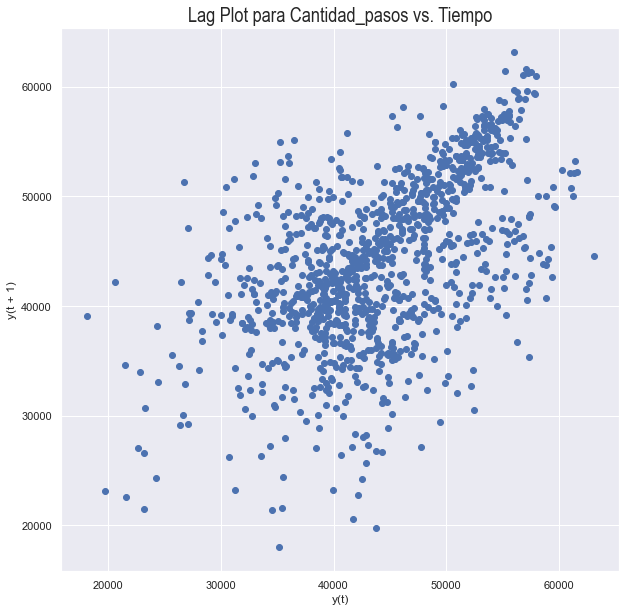

In [65]:
plt.figure(figsize = (10,10))
pd.plotting.lag_plot(diario, lag=1)
plt.title("Lag Plot para Cantidad_pasos vs. Tiempo", size=20, stretch=50)

Posteriormente, se analiza primero la FAS (autocorrelación simple).

In [66]:
nlags = 7*4
autocorr = acf(diario.cantidad_pasos, nlags = nlags)
autocorr

C:\Users\SMFernandez\.conda\envs\timeseries\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


array([1.        , 0.54478421, 0.28920301, 0.22668316, 0.216068  ,
       0.28851551, 0.48574835, 0.64535382, 0.44157659, 0.26341179,
       0.22693945, 0.19491802, 0.24733   , 0.43449858, 0.59565115,
       0.42740746, 0.25627763, 0.2075221 , 0.20520575, 0.24746752,
       0.42356574, 0.57741732, 0.42299232, 0.2475694 , 0.20636263,
       0.19715044, 0.22094119, 0.39641333, 0.56961341])

In [67]:
autocorr.shape

(29,)

In [68]:
diario.cantidad_pasos.autocorr(lag=7*4)

0.5956057431218374

In [69]:
PorcDiff = diario.cantidad_pasos.pct_change(periods=7*4)
PorcDiff = PorcDiff.dropna()
PorcDiff

fecha
2017-01-29    0.321810
2017-01-30    0.082338
2017-01-31    0.034232
2017-02-01    0.042826
2017-02-02    0.023174
                ...   
2019-12-27   -0.103900
2019-12-28   -0.264633
2019-12-29    0.277624
2019-12-30   -0.182210
2019-12-31   -0.461401
Freq: D, Name: cantidad_pasos, Length: 1067, dtype: float64

In [70]:
PorcDiff.autocorr()

0.2916214345767806

Posteriormente se grafica un correlograma para distintos valores de retardo k. Esto nos da la pauta de los valores de retardo para los cuales se tiene coeficiente de correlación válidos.

Con retraso de 1 año:

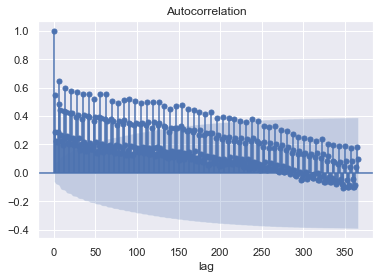

In [71]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(diario.cantidad_pasos, lags = 365)
plt.xlabel("lag")
plt.show()

C:\Users\SMFernandez\.conda\envs\timeseries\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


Text(0.5, 0, 'lag')

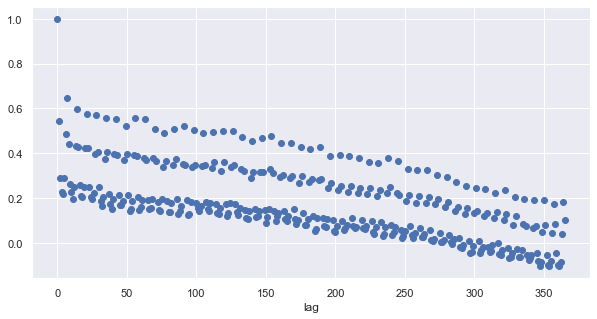

In [72]:
autocorr_365 = acf(diario.cantidad_pasos, nlags = 365)
autocorr_365

plt.figure(figsize = (10,5))
plt.scatter(np.arange(365+1), autocorr_365)
plt.xlabel('lag')

Con retraso de 28 días:

Text(0.5, 0, 'lag')

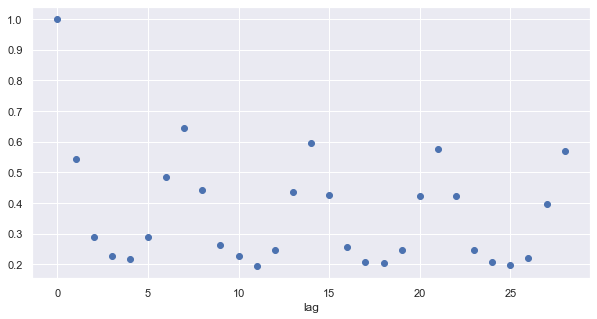

In [73]:
plt.figure(figsize = (10,5))
plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')

En el gráfico anterior se observa que **la autocorrelación de la cantidad de pasos de vehículos es positiva**. Esto significa que hay una relación lineal positiva entre la variable cantidad_pasos y la misma variable un tiempo anterior. Además, se observa un patrón de comportamiento. **Cada 7 días la autocorrelación se comporta de la misma manera**. Se podría decir que la cantidad de vehículos que circulan un día determinado está muy relacionada con la cantidad de vehículos que circularon ese mismo día la semana anterior. También, se aprecia que la autocorrelación para un mismo día (por ejemplo, un mismo viernes) disminuye semana a semana

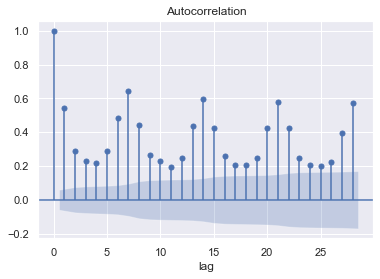

In [74]:
plot_acf(diario.cantidad_pasos, lags = nlags)
plt.xlabel("lag")
plt.show()

En este correlograma se destaca que los coeficientes de autocorrealción son válidos, ya que se establece que los valores dentro del cono en color azul representa un intervalo de confianza del 95% que sugiere que los valores de correlación fuera de este cono son muy probablemente una correlación y no una casualidad estadística.

Por otro lado, considerando la autocorrelación parcial FAP se obtiene lo siguiente.

In [75]:
nlags_par = 7*4
autocorr_par = stattools.pacf(diario.cantidad_pasos, nlags = nlags_par)
autocorr_par

array([ 1.00000000e+00,  5.45282189e-01, -1.08165886e-02,  1.04626935e-01,
        7.78643560e-02,  1.82246668e-01,  3.61102089e-01,  4.07240964e-01,
       -3.37784810e-02, -1.64849589e-02,  3.93081674e-02, -4.61161735e-02,
       -2.22430131e-02,  1.09224776e-01,  2.40635493e-01, -2.91472434e-03,
       -2.67528433e-02, -1.21389099e-03,  4.93297837e-02, -1.51042400e-02,
        6.46882074e-02,  1.72676394e-01,  1.22398014e-02, -3.94740185e-02,
        7.60260127e-04,  1.19941268e-02, -5.16648401e-02,  3.05231636e-02,
        1.61284325e-01])

Text(0.5, 0, 'lag')

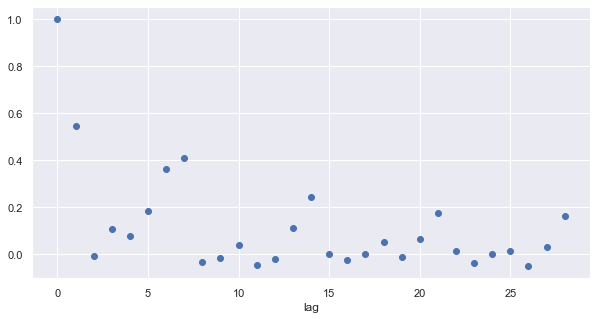

In [76]:
plt.figure(figsize = (10,5))
plt.scatter(np.arange(nlags_par+1), autocorr_par)
plt.xlabel('lag')

Text(0.5, 0, 'lag')

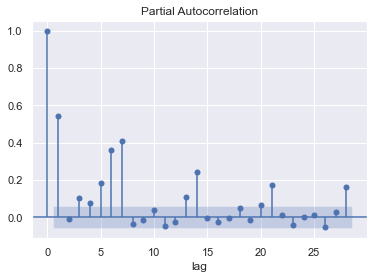

In [77]:
plot_pacf(diario, lags= 7*4)
plt.xlabel('lag')

En este último gráfico se evidencia la eliminación del efecto de la autocorrelación de los valores con intervalos de tiempo intermedios menores a k (al retraso). Se sigue observando que la relación entre la variable cantidad_ pasos consigo misma un tiempo anterior es directa cuando el retraso es t-1, t-3, t-4, t-5, t-6, t-7, t-13, t-14, t-21, t-28. Esto demuestra también que hay cierta periodicidad cada 7 días. **Podríamos decir que la serie es estacionaria con periodo igual a 7**. Otra información que puede darnos este indicio es que la autocorrelación baja rápidamente hasta oscilar en cero, punto en el cual la autocorrelación ya no es significativa.

### 3. Componentes de la serie

Algunas series de tiempo se comportan como $Tendencia + Estacionalidad + Ruido$, mientras que otras tienen comportamientos más complejos, como $Tendencia * Estacionalidad + Ruido$. Por lo tanto, obtener las componentes de la serie puede ser complejo. En este caso, se utilizarán varios métodos de descomponer la serie de tiempo y luego se elegirá uno de ellos según observemos qué método representa mejor a la serie. Los métodos a utilizar son *media móvil* y *tendencia lineal*. Posteriormente, se utilizará la librería *Statsmodels* para realizar la misma descomposición.

#### 3.1 Método de Media Móvil

Se toma una ventana de tiempo suficientemente grande y se promedia la serie sobre esa ventana. De esta forma, se obtiene la tendencia. Una característica de este método es que no asume ninguna forma para la serie de tiempo, así que suele funcionar en muchos casos.

In [78]:
ventana = int(365/12)
ventana

30

In [79]:
diario_promedio_tendencia = diario.cantidad_pasos.rolling(window=ventana, center = True).mean()
diario_promedio_tendencia

fecha
2017-01-01   NaN
2017-01-02   NaN
2017-01-03   NaN
2017-01-04   NaN
2017-01-05   NaN
              ..
2019-12-27   NaN
2019-12-28   NaN
2019-12-29   NaN
2019-12-30   NaN
2019-12-31   NaN
Freq: D, Name: cantidad_pasos, Length: 1095, dtype: float64

In [80]:
diario_promedio_tendencia.isna().sum()

29

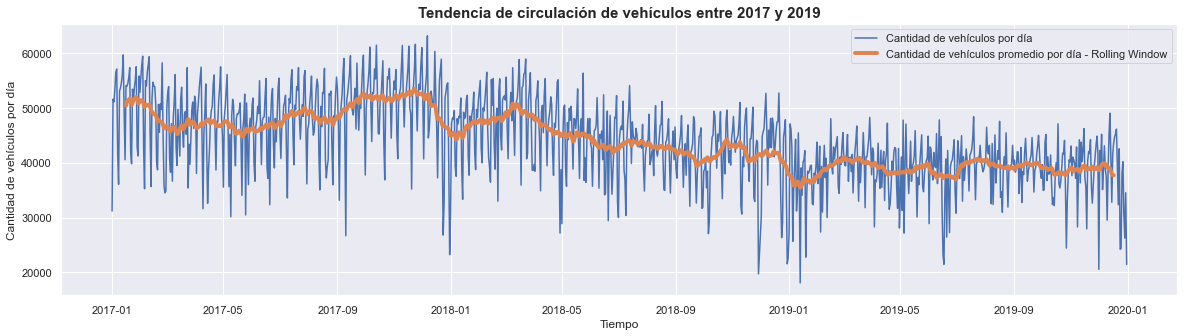

In [81]:
plt.figure(figsize = (20,5))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad de vehículos por día')
plt.plot(diario_promedio_tendencia, lw = 4, label = 'Cantidad de vehículos promedio por día - Rolling Window')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.title('Tendencia de circulación de vehículos entre 2017 y 2019', fontsize=15, fontweight='bold', fontstretch='normal')
plt.legend()
plt.show()

#### 3.2 Método de Tendencia Lineal

Este método consiste simplemente en ajustar una regresión lineal a la serie.
Para comenzar, lo único que tenemos que tener en cuenta es que no se puede ajustar una regresión lineal con las fechas así como las tenemos, por lo que tenemos que pasarlas a un formato numérico.

In [82]:
diario['fecha_numeros']=diario.index.map(datetime.datetime.toordinal)
diario.head()

cantidad_pasos  fecha_numeros
fecha                                    
2017-01-01         31183.0         736330
2017-01-02         51568.0         736331
2017-01-03         51093.0         736332
2017-01-04         53332.0         736333
2017-01-05         56486.0         736334

In [83]:
diario.fecha_numeros.values

array([736330, 736331, 736332, ..., 737422, 737423, 737424], dtype=int64)

In [84]:
diario.fecha_numeros.values.reshape(-1, 1)

array([[736330],
       [736331],
       [736332],
       ...,
       [737422],
       [737423],
       [737424]], dtype=int64)

In [85]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(diario.fecha_numeros.values.reshape(-1, 1), diario.cantidad_pasos)

LinearRegression()

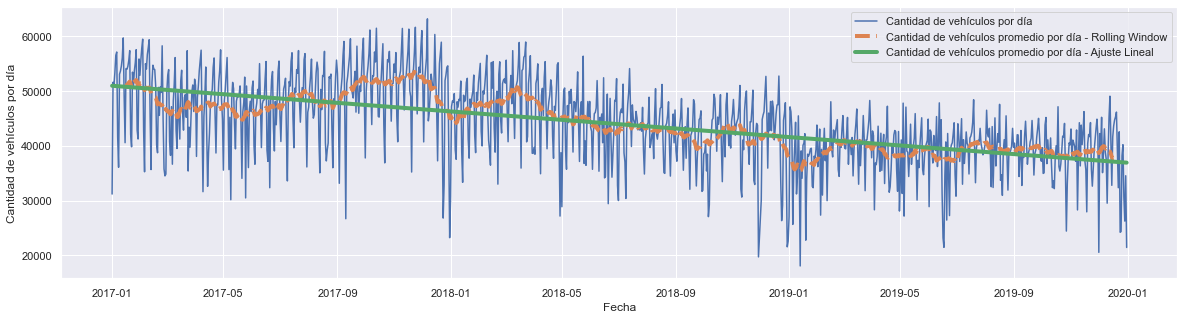

In [86]:
plt.figure(figsize = (20,5))
plt.plot(diario.index, diario.cantidad_pasos, label = 'Cantidad de vehículos por día')
plt.plot(diario_promedio_tendencia, ls = '--', lw = 4, label = 'Cantidad de vehículos promedio por día - Rolling Window')
plt.plot(diario.index, lr.predict(diario.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Cantidad de vehículos promedio por día - Ajuste Lineal')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de vehículos por día')
plt.legend()
plt.show()

#### 3.3 Descomposición de la serie de tiempo aditiva: Tendencia + Estacionalidad + Ruido

Se parte de considerar un comportamiento aditivo de la serie de tiempo.

Luego de obtener la tendencia en el gráfico anterior, se resta la tendencia de la serie para obtener una nueva serie sin tendencia. Se espera que la componente resultante sea una serie con predominio de la componente estacional.

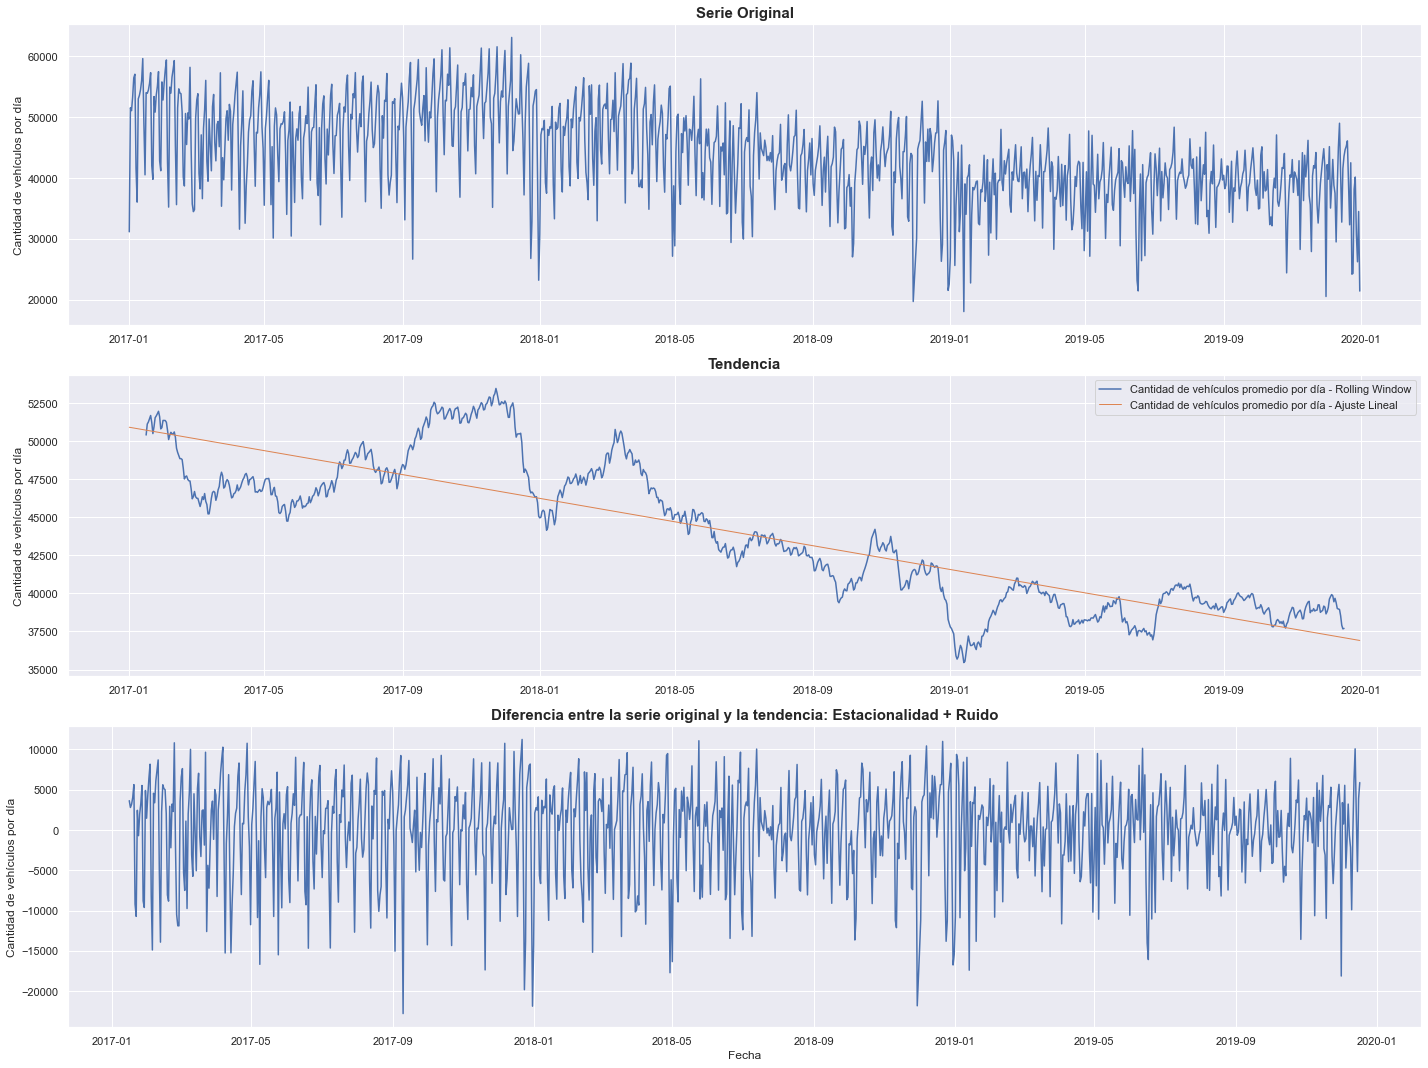

In [87]:
plt.figure(figsize = (20,15))

plt.subplot(3,1,1)
plt.title('Serie Original', fontsize=15, fontweight='bold', fontstretch='normal')
plt.plot(diario.index, diario.cantidad_pasos)
plt.ylabel('Cantidad de vehículos por día')

plt.subplot(3,1,2)
plt.title('Tendencia', fontsize=15, fontweight='bold', fontstretch='normal')
plt.plot(diario_promedio_tendencia, label = 'Cantidad de vehículos promedio por día - Rolling Window')
plt.plot(diario.index, lr.predict(diario.fecha_numeros.values.reshape(-1, 1)), lw = 1, label = 'Cantidad de vehículos promedio por día - Ajuste Lineal')
plt.ylabel('Cantidad de vehículos por día')
plt.legend()

plt.subplot(3,1,3)
plt.title('Diferencia entre la serie original y la tendencia: Estacionalidad + Ruido', fontsize=15, fontweight='bold', fontstretch='normal')
plt.plot(diario.index, diario.cantidad_pasos - diario_promedio_tendencia)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de vehículos por día')

plt.tight_layout()
plt.show()

Finalmente, se podría obtener la componente estacional asumiendo una forma armónica (tipo seno o coseno). Es decir, se puede hacer un procedimiento similar al heco con la tendencia (ajustar y restar a la serie sin tendencia) para obtener ruido + componentes restantes. Este paso se hará mediante librerías.

#### 3.4 Descomposición de la serie de tiempo multiplicativa: Tendencia * Estacionalidad + Ruido

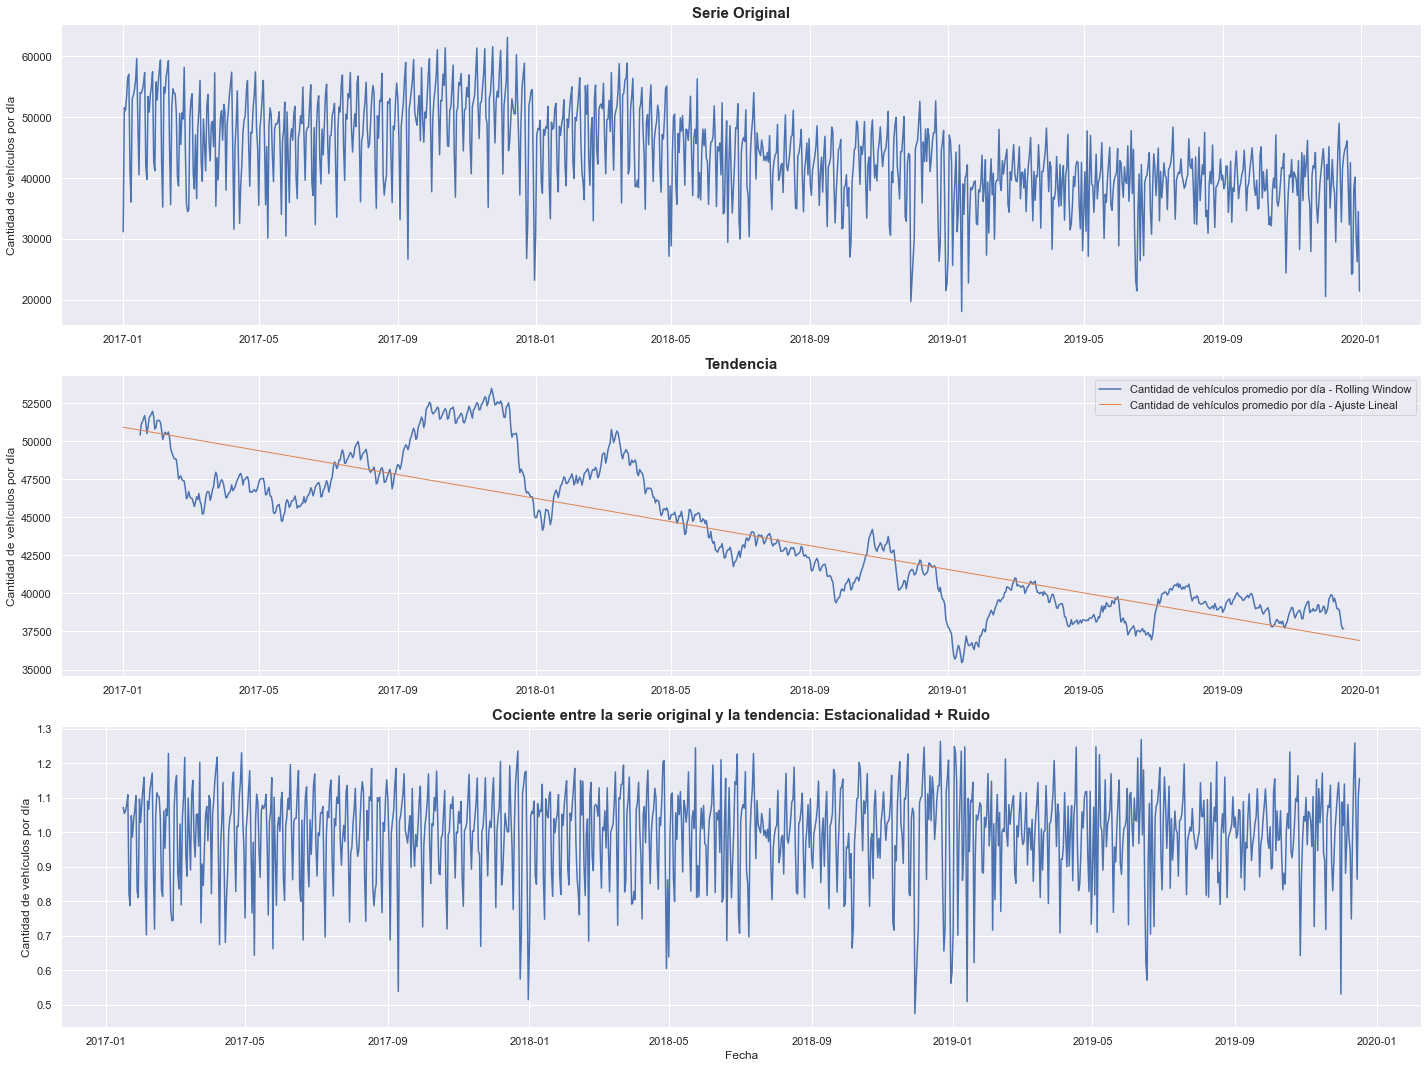

In [88]:
plt.figure(figsize = (20,15))

plt.subplot(3,1,1)
plt.title('Serie Original', fontsize=15, fontweight='bold', fontstretch='normal')
plt.plot(diario.index, diario.cantidad_pasos)
plt.ylabel('Cantidad de vehículos por día')

plt.subplot(3,1,2)
plt.title('Tendencia', fontsize=15, fontweight='bold', fontstretch='normal')
plt.plot(diario_promedio_tendencia, label = 'Cantidad de vehículos promedio por día - Rolling Window')
plt.plot(diario.index, lr.predict(diario.fecha_numeros.values.reshape(-1, 1)), lw = 1, label = 'Cantidad de vehículos promedio por día - Ajuste Lineal')
plt.ylabel('Cantidad de vehículos por día')
plt.legend()

plt.subplot(3,1,3)
plt.title('Cociente entre la serie original y la tendencia: Estacionalidad + Ruido', fontsize=15, fontweight='bold', fontstretch='normal')
plt.plot(diario.index, diario.cantidad_pasos / diario_promedio_tendencia)
plt.xlabel('Fecha')
plt.ylabel('Cantidad de vehículos por día')

plt.tight_layout()
plt.show()

#### 3.5 Descomposición de la serie de tiempo usando Statsmodels

##### 3.5.1 Statsmodels con serie aditiva: Tendencia + Estacionalidad + Ruido

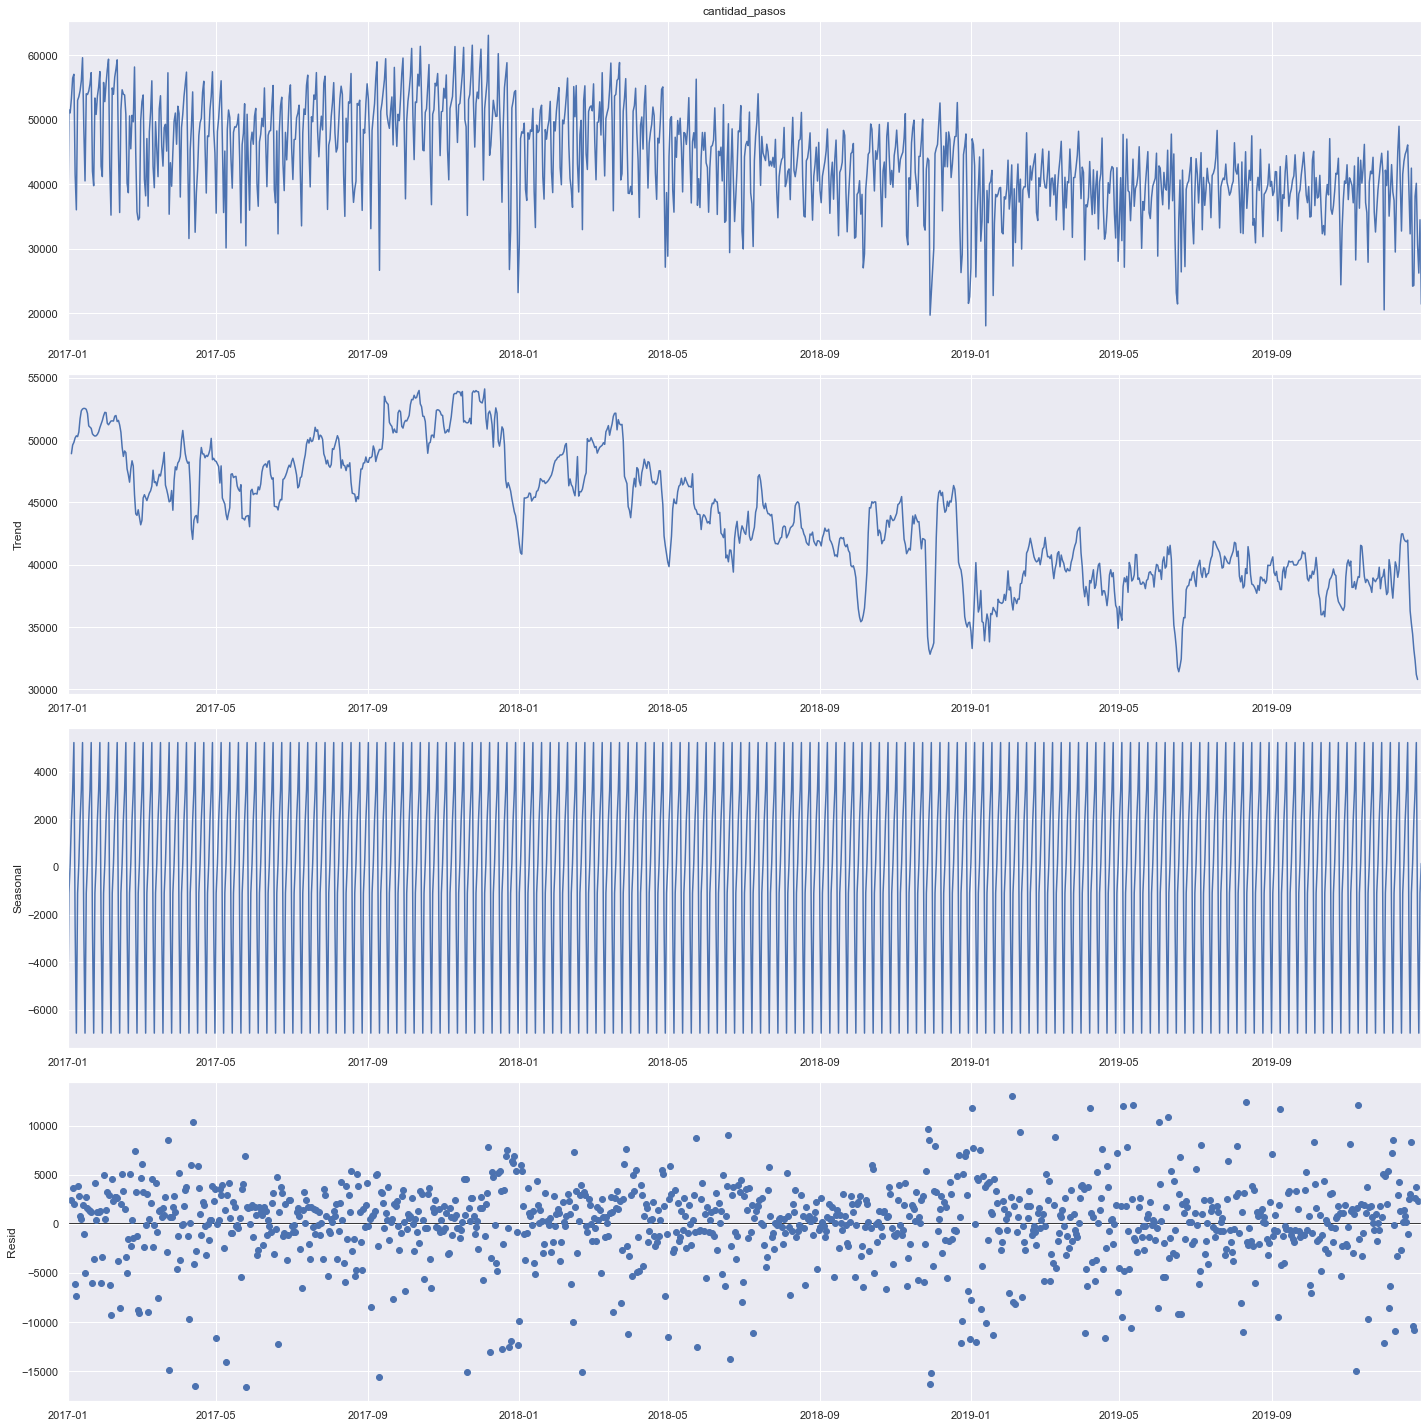

In [89]:
result_additive = seasonal_decompose(diario.cantidad_pasos, model='additive')
plt.rcParams['figure.figsize'] = [20,20]
result_additive.plot()
plt.show()

Luego, se analizan los residuos a través de un histograma. Se debe corroborar que los residuos posean una distribución normal para considerar una buena estimación.

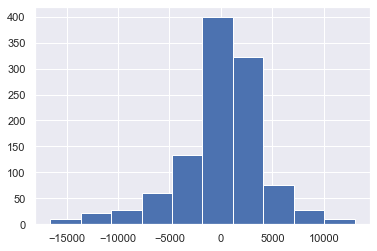

In [90]:
plt.figure(figsize = (6,4))
plt.hist(result_additive.resid)
plt.show()

##### 3.5.1 Statsmodels con serie multiplicativa: Tendencia * Estacionalidad * Ruido

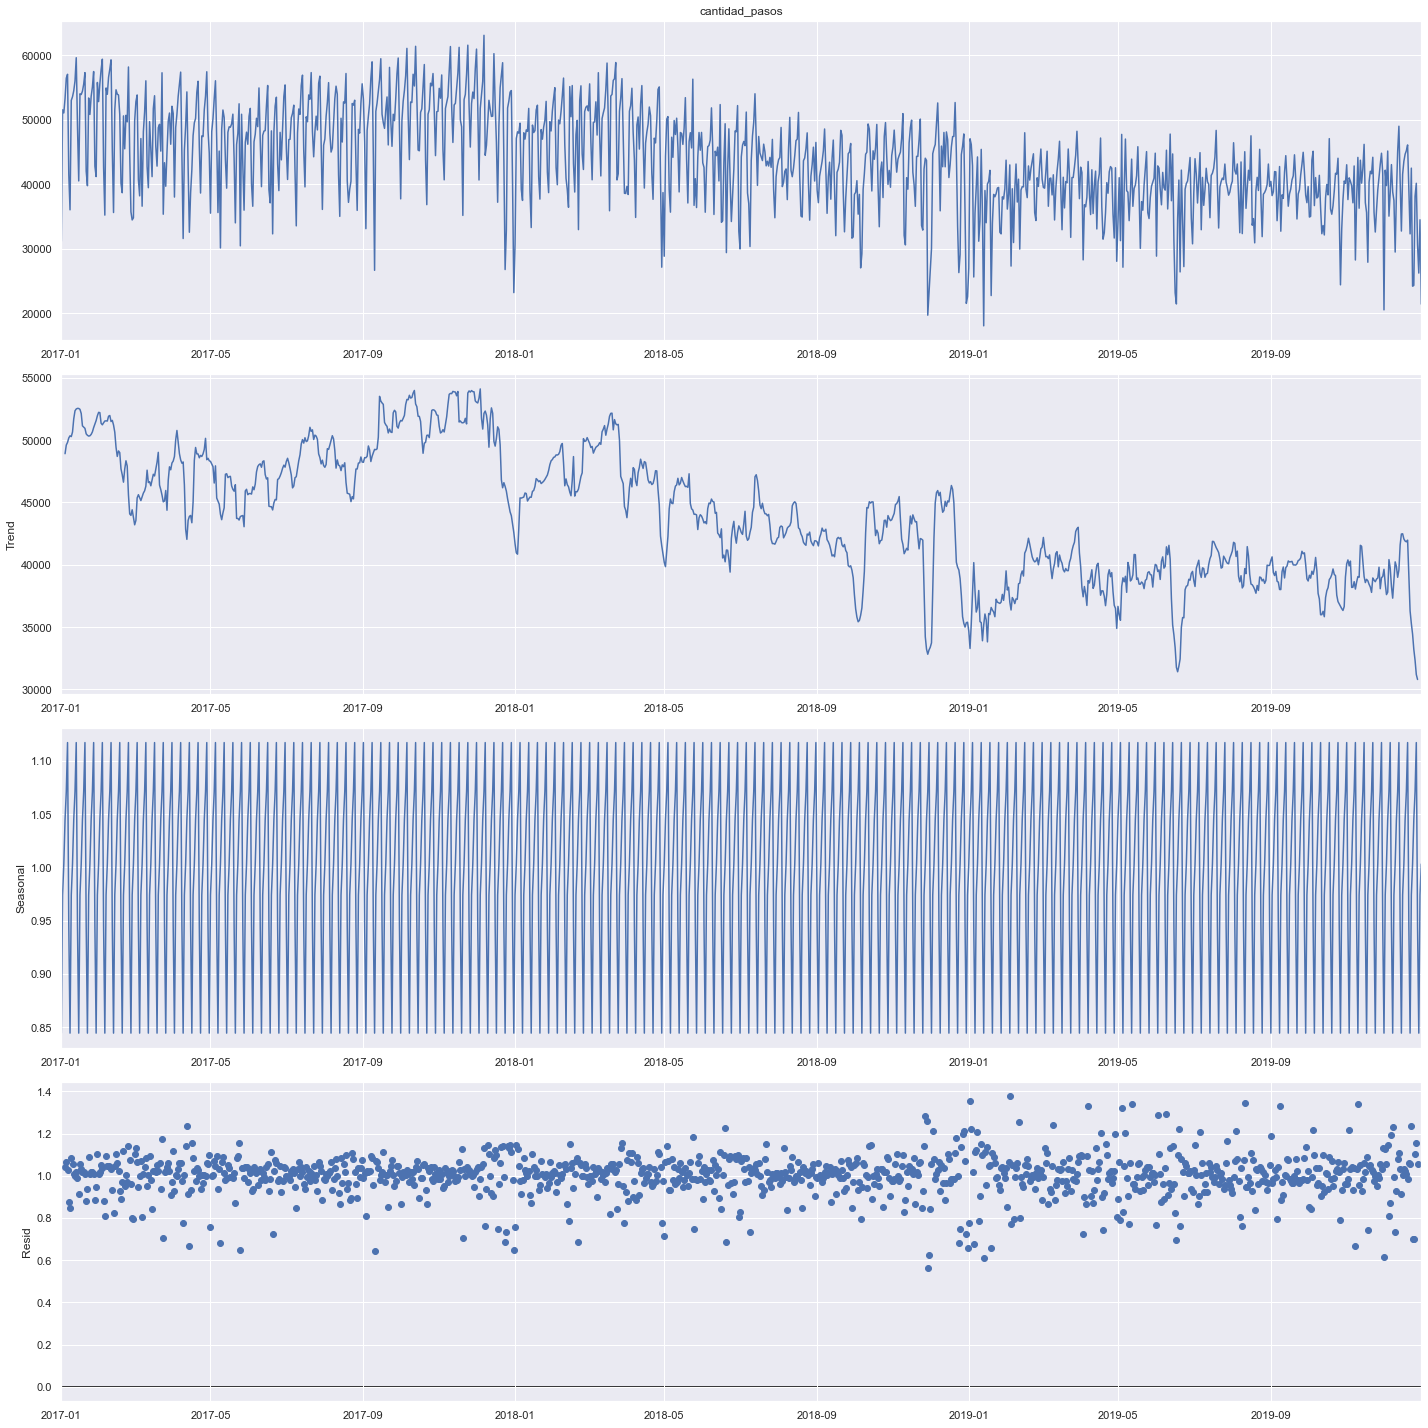

In [91]:
result_mult = seasonal_decompose(diario.cantidad_pasos, model='multiplicative')
plt.rcParams['figure.figsize'] = [20,20]
result_mult.plot()
plt.show()

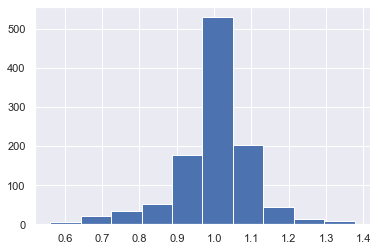

In [92]:
plt.figure(figsize = (6,4))
plt.hist(result_mult.resid)
plt.show()

Una manera de seleccionar cuál es la descomposición correcta es usando un enfoque gráfico. En un modelo aditivo, la magnitud de la estacionalidad no cambia en relación al tiempo, es decir, el modelo aditivo no varía en frecuencia y amplitud con el tiempo. La estacionalidad es independiente de la variación de la tendencia. Por otro lado, en un modelo multiplicativo la magnitud del patrón estacional en los datos depende de la magnitud de los datos. La amplitud o frecuencia de la serie de tiempo puede ser creciente o decreciente a lo largo del tiempo. En otras palabras, ante aumentos de la tendencia T, la relación tendencia estacionalidad T*E producirá valores mayores.

Text(0, 0.5, 'Cantidad de vehículos por día')

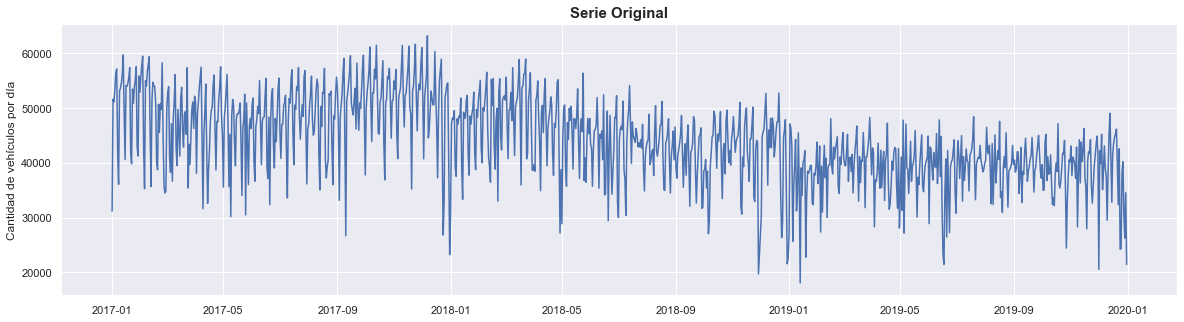

In [93]:
plt.figure(figsize = (20,5))


plt.title('Serie Original', fontsize=15, fontweight='bold', fontstretch='normal')
plt.plot(diario.index, diario.cantidad_pasos)
plt.ylabel('Cantidad de vehículos por día')

Si se observa el gráfico de la serie, podríamos decir que la amplitud y frecuencia se mantienen constante hasta mediados del año 2019. Luego, esto empieza a ser difuso, ya que la tendencia cae y la amplitud se reduce pero luego mantiene cierta constancia.

Un segundo enfoque, más analítico, está basado en la representatividad de los efectos estacionales. Si suponemos que la serie es trimestral, para detectar los efectos estacionales se pueden comparar los valores de un mismo trimestre (i) para años consecutivos (k y k+1), bien a través de su cociente ci = yi,k+1 /yi,k o a través de su diferencia di = yi,k+1 -yi,k. Si la serie es multiplicativa, los cocientes entre años consecutivos serán muy parecidos, ya que solo se diferenciarán por los efectos de la componente irregular, mientras que las diferencias variarán mucho más, ya que dependerán de qué año se esté utilizando. Por otro lado, si la serie es aditiva, las diferencias sí presentarán valores muy homogéneos, mientras que variarán más los cocientes. Así, una posible forma de distinguir entre ambos modelos consiste en determinar qué distribución es más homogénea, la de los cocientes o la de las diferencias. Como medida de homogeneidad se utiliza habitualmente el coeficiente de variación de Pearson. Por lo tanto, si el coeficiente de variación de los cocientes es menor que el de las diferencias, se admite el modelo multiplicativo como más apropiado. En caso contrario, se concluye que es el aditivo el que mejor se ajusta a los datos.

In [94]:
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha  \
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00   
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00   
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00   
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00   
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00   
...         ...        ...           ...             ...                 ...   
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00   
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00   
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00   
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00   
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00   

         Horario  solo_fecha   año  
0       00:00:00  2017-01-01  2017  
1       00:00:00  2017-01-01  2017  
2       00:00:00  2017-01-01  2017  
3       00:00:00  2017-01-01  2017  
4       00:00:00  2017-01-01  2017  
...          ...         ...   ...  
238864  22:00:00  2019-12-31  2019  
238865  22:00:00  2019-12-31  2019  
238866  22:00:00  2019-12-31  2019  
238867  23:00:00  2019-12-31  2019  
238868  23:00:00  2019-12-31  2019  

[238869 rows x 8 columns]

In [95]:
diario_2018 = dataset[dataset.año==2018].resample('D', on = 'fecha').sum()
diario_2018 = diario_2018.reset_index()
diario_2018 = diario_2018.drop(columns = "año")
diario_2018_1ertrim = diario_2018[diario_2018.fecha<='2018-03-31']
diario_2018_1ertrim

fecha  cantidad_pasos
0  2018-01-01           30735
1  2018-01-02           47130
2  2018-01-03           48162
3  2018-01-04           47953
4  2018-01-05           49505
..        ...             ...
85 2018-03-27           53358
86 2018-03-28           56407
87 2018-03-29           47490
88 2018-03-30           38627
89 2018-03-31           38603

[90 rows x 2 columns]

In [96]:
diario_2019 = dataset[dataset.año==2019].resample('D', on = 'fecha').sum()
diario_2019 = diario_2019.reset_index()
diario_2019 = diario_2019.drop(columns = "año")
diario_2019_1ertrim = diario_2019[diario_2019.fecha<='2019-03-31']
diario_2018_1ertrim

fecha  cantidad_pasos
0  2018-01-01           30735
1  2018-01-02           47130
2  2018-01-03           48162
3  2018-01-04           47953
4  2018-01-05           49505
..        ...             ...
85 2018-03-27           53358
86 2018-03-28           56407
87 2018-03-29           47490
88 2018-03-30           38627
89 2018-03-31           38603

[90 rows x 2 columns]

In [97]:
div = diario_2019_1ertrim.cantidad_pasos/diario_2018_1ertrim.cantidad_pasos
div

0     0.879714
1     0.998939
2     0.959138
3     0.894355
4     0.518129
        ...   
85    0.800386
86    0.789583
87    1.015898
88    1.118466
89    0.979121
Name: cantidad_pasos, Length: 90, dtype: float64

In [98]:
Coef_div = np.std(div)/abs(np.mean(div))
Coef_div

0.18143123436088401

In [99]:
resta = diario_2019_1ertrim.cantidad_pasos-diario_2018_1ertrim.cantidad_pasos
resta

0     -3697
1       -50
2     -1968
3     -5066
4    -23855
      ...  
85   -10651
86   -11869
87      755
88     4576
89     -806
Name: cantidad_pasos, Length: 90, dtype: int64

In [100]:
Coef_resta = np.std(resta)/abs(np.mean(resta))
Coef_resta

0.8254208813009232

Según el enfoque más analítico, la serie se comporta mejor con un modelo de descomposición multiplicativo.

## PARTE B - Modelo de Machine Learning

### 3. Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

#### 3.1 Transformaciones necesarias para comenzar la predicción

Para comenzar a implementar un modelo de predicción del tráfico de vehículos por la autopista Illia con pago en efectivo para el último trimestre del 2019 se tiene que considerar el dataset resultante del análisis EDA hecho previamente.

In [101]:
diario = diario.drop(columns = "fecha_numeros")
diario

cantidad_pasos
fecha                     
2017-01-01         31183.0
2017-01-02         51568.0
2017-01-03         51093.0
2017-01-04         53332.0
2017-01-05         56486.0
...                    ...
2019-12-27         40182.0
2019-12-28         30681.0
2019-12-29         26259.0
2019-12-30         34523.0
2019-12-31         21447.0

[1095 rows x 1 columns]

#### 3.2 Métrica seleccionada para evaluar reasultados

La métrica que vamos a utilizar para evaluar los distintos modelos es la raíz del error cuadrático medio (RMSE). Se estudiará el caso de la aplicación de alguna métrica más de ser necesario, como puede ser el caso de MAPE (Error porcentual absoluto medio) que está definido por la fórmula: 

\begin{equation}
MAPE=\frac{100%}{n}\sum_{i=0}^n\frac{y_{i}-\hat{y}}{y_{i}}
\end{equation}

Esta métrica suele ser usada en series de tiempo para tener noción del error relativo entre el valor real y el predicho por algún modelo de regresión.

In [102]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#### 3.3 Modelo Benchmark

Para definir el modelo Bechmark con el cual se compararán los resultados de los modelos más complejos de ML se parte de considerar que los valores futuros de la serie de tiempo se comportaran de igual manera que los valores del pasado. Por ende, se copia el valor de la fecha anterior. Hay que aclarar que se está prediciendo un valor a la vez (One Step Prediction).

Primero, se define cuántos valores hacia atrás se van a tomar para predecir el valor siguiente.

In [103]:
look_back = 90 # se usan 90 días para predecir lo que sucederá en el siguiente trimestre.

N = diario.cantidad_pasos.shape[0]
N

1095

Creamos los `X` e `y` con ceros para luego llenar con los datos.

In [104]:
X = np.zeros((N - look_back - 1,look_back))
y = np.zeros(N - look_back - 1)
print(X.shape, y.shape)

(1004, 90) (1004,)


In [105]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [106]:
y

array([0., 0., 0., ..., 0., 0., 0.])

Llenamos los `X` e `y`

In [107]:
for i in range(X.shape[0]):
#     X[i,:] = senial.values.iloc[i:i+look_back]
#     y[i] = senial.values.iloc[i+look_back]
    X[i,:] = diario.cantidad_pasos.iloc[i:i+look_back]
    y[i] = diario.cantidad_pasos.iloc[i+look_back]

In [108]:
print(X)

[[31183. 51568. 51093. ... 51074. 46235. 52127.]
 [51568. 51093. 53332. ... 46235. 52127. 50995.]
 [51093. 53332. 56486. ... 52127. 50995. 38045.]
 ...
 [38348. 37170. 39669. ... 24349. 38168. 40182.]
 [37170. 39669. 34943. ... 38168. 40182. 30681.]
 [39669. 34943. 35054. ... 40182. 30681. 26259.]]


In [109]:
print(y)

[50995. 38045. 48833. ... 30681. 26259. 34523.]


Acá destacamos que los valores de tiempo, la fecha, ya no es parte de los datos. Sabemos que cada valor que se toma hacia atrás corresponde a un día anterior.

Hacemos el train/test split. Se elige un periodo de los 2 años y medio más antiguos de datos para utilizarlos con datos de entrenamiento (corresponde a 913 días). Luego, se usa medio año de los datos más recientes para testear. Por eso, los valores de testeo son los 182 días más recientes de la serie de tiempo.

In [110]:
N_train = 913 - look_back # cantidad de instancias que vamos a usar para entrenar. 
N_test = 182 #cantidad de puntos que vamos a usar para evaluar
N_total = N_train + N_test
print(f'N_total: {N_total}')

length_total = N_train + N_test + look_back
print(f'length_total: {length_total}')

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

N_total: 1005
length_total: 1095
(823, 90) (823,)
(181, 90) (181,)


In [111]:
X_train

array([[31183., 51568., 51093., ..., 51074., 46235., 52127.],
       [51568., 51093., 53332., ..., 46235., 52127., 50995.],
       [51093., 53332., 56486., ..., 52127., 50995., 38045.],
       ...,
       [42686., 41861., 28303., ..., 42227., 44179., 34754.],
       [41861., 28303., 36853., ..., 44179., 34754., 30793.],
       [28303., 36853., 36537., ..., 34754., 30793., 38705.]])

In [112]:
y_train

array([50995. , 38045. , 48833. , 50891. , 53655. , 55537. , 57419. ,
       44409. , 31615. , 45346. , 49017. , 54351. , 42650. , 32588. ,
       38688. , 42272. , 47573. , 49557. , 50244. , 54288. , 56002. ,
       45893. , 38668. , 47529. , 47420. , 51580. , 53686. , 57473. ,
       48393. , 44865. , 35547. , 48208. , 50211. , 53313. , 56077. ,
       46876. , 35643. , 45178. , 30152. , 48562. , 51543. , 50388. ,
       43826. , 39423. , 48099. , 48938. , 48873. , 49381. , 50899. ,
       44007. , 34043. , 46186. , 47902. , 52506. , 30479. , 50885. ,
       43087. , 36009. , 46552. , 48109. , 46234. , 50576. , 51795. ,
       40054. , 36617. , 46609. , 47788. , 50266. , 48962. , 54965. ,
       46901. , 39656. , 47622. , 48274. , 48349. , 52191. , 55347. ,
       39192. , 37147. , 48306. , 32336. , 48103. , 52155. , 53526. ,
       43183. , 39042. , 48073. , 43811. , 48559. , 53626. , 55433. ,
       45628. , 40770. , 46961. , 47005. , 50344. , 51034. , 52293. ,
       41944. , 3357

In [113]:
X_test

array([[36853., 36537., 37999., ..., 30793., 38705., 43996.],
       [36537., 37999., 43558., ..., 38705., 43996., 41613.],
       [37999., 43558., 38586., ..., 43996., 41613., 37124.],
       ...,
       [38348., 37170., 39669., ..., 24349., 38168., 40182.],
       [37170., 39669., 34943., ..., 38168., 40182., 30681.],
       [39669., 34943., 35054., ..., 40182., 30681., 26259.]])

In [114]:
y_test

array([41613., 37124., 40815., 44932., 32975., 41090., 36759., 39193.,
       42509., 40438., 40021., 34842., 41401., 41753., 42488., 44261.,
       48381., 39900., 33247., 39618., 40445., 40990., 40757., 43164.,
       40348., 39500., 38338., 38817., 39904., 40493., 46468., 42150.,
       41603., 43174., 38276., 32510., 43488., 32379., 38965., 45075.,
       36295., 39448., 42198., 40647., 47543., 33680., 34702., 30943.,
       39078., 41105., 39066., 45447., 38050., 31905., 38482., 38760.,
       39207., 39986., 43164., 39703., 40473., 38274., 38869., 41994.,
       41954., 34380., 38023., 42777., 32750., 38391., 37842., 41912.,
       44463., 40606., 36628., 38539., 39293., 40707., 41326., 44596.,
       40820., 34646., 38523., 39191., 41486., 43110., 44985., 41925.,
       38348., 37170., 39669., 34943., 35054., 43775., 45150., 36722.,
       41064., 37894., 38100., 41414., 36383., 32359., 33626., 32168.,
       37928., 39997., 38379., 47105., 36187., 35383., 36687., 38960.,
      

Se representan los datos de Train y Test para ser más gráfico.

Observations: 1095
Training Observations: 913
Testing Observations: 182


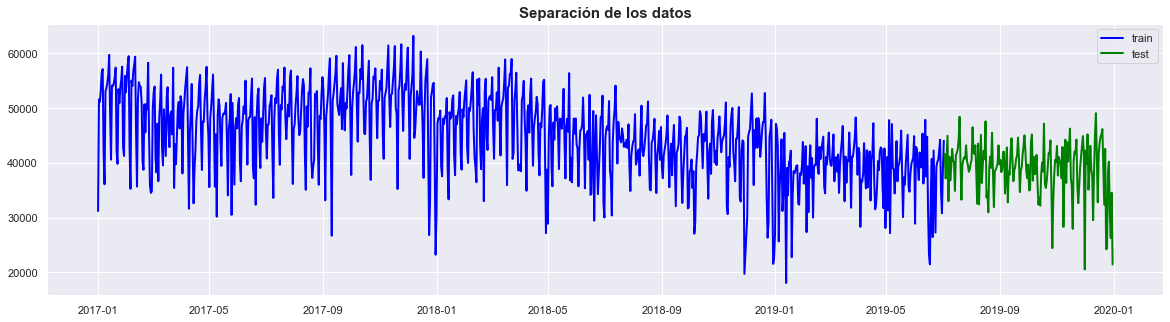

In [115]:
plt.figure(figsize = (20,5))


train_size = int(len(diario.cantidad_pasos) -182)
train, test = pd.DataFrame(diario.cantidad_pasos[0:train_size]), pd.DataFrame(diario.cantidad_pasos[train_size:len(diario.cantidad_pasos)])
print('Observations: %d' % (len(diario.cantidad_pasos)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

plt.plot(train.index, train.cantidad_pasos,
         color='blue', lw=2, label="train")
plt.plot(test.index, test.cantidad_pasos,
         color='green', lw=2, label="test")
plt.legend()
plt.title("Separación de los datos", fontsize=15, fontweight='bold', fontstretch='normal')
plt.show()

Finalmente, se define el **modelo Benchmark** si se predicen los valores futuros copiando el valor de la fecha anterior.

In [116]:
y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 2]
print(y_test_pred_benchmark.shape)
y_test_pred_benchmark

(181,)


array([43996., 41613., 37124., 40815., 44932., 32975., 41090., 36759.,
       39193., 42509., 40438., 40021., 34842., 41401., 41753., 42488.,
       44261., 48381., 39900., 33247., 39618., 40445., 40990., 40757.,
       43164., 40348., 39500., 38338., 38817., 39904., 40493., 46468.,
       42150., 41603., 43174., 38276., 32510., 43488., 32379., 38965.,
       45075., 36295., 39448., 42198., 40647., 47543., 33680., 34702.,
       30943., 39078., 41105., 39066., 45447., 38050., 31905., 38482.,
       38760., 39207., 39986., 43164., 39703., 40473., 38274., 38869.,
       41994., 41954., 34380., 38023., 42777., 32750., 38391., 37842.,
       41912., 44463., 40606., 36628., 38539., 39293., 40707., 41326.,
       44596., 40820., 34646., 38523., 39191., 41486., 43110., 44985.,
       41925., 38348., 37170., 39669., 34943., 35054., 43775., 45150.,
       36722., 41064., 37894., 38100., 41414., 36383., 32359., 33626.,
       32168., 37928., 39997., 38379., 47105., 36187., 35383., 36687.,
      

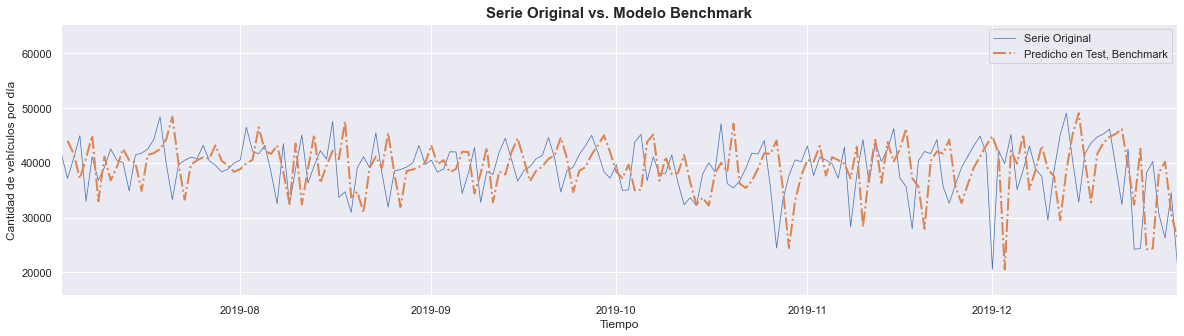

In [117]:
plt.figure(figsize = (20,5))

plt.plot(diario.cantidad_pasos.index[:length_total], diario.cantidad_pasos[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.cantidad_pasos.index[N_train+look_back+1: length_total], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(diario.cantidad_pasos.index[N_train+look_back], diario.cantidad_pasos.index[length_total-1])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.title("Serie Original vs. Modelo Benchmark", fontsize=15, fontweight='bold', fontstretch='normal')
plt.legend()
plt.show()

In [118]:
rmse_test_benchmark =  np.sqrt(mean_squared_error(y_test, y_test_pred_benchmark))
print(f'RMSE EN TEST, MODELO BENCHMARK: {round(rmse_test_benchmark,2)}')

RMSE EN TEST, MODELO BENCHMARK: 5907.95


In [119]:
MAPE_test_benchmark = mean_absolute_percentage_error(y_test, y_test_pred_benchmark)*100
print(f'MAPE EN TEST, MODELO BENCHMARK: {round(MAPE_test_benchmark,2)} %')

MAPE EN TEST, MODELO BENCHMARK: 12.27 %


Con este modelo se van a comparar el resto de los modelos que se platearán a continuación, enfocándose en el error que genera cada unos de ellos.

#### 3.4 Modelos de ML

##### 3.4.1 Random Forest Regressor + One-Step Prediction

Se entrenará un modelo RandomForestRegressor para predecir el siguiente valor en la serie de tiempo diaria de pasos de vehículos que pasan por la Autopista Illia, pagando en efectivo. Se utilizarán datos desde 2017-01-01 hasta 2019-08-31 como conjunto de entrenamiento y el último trimestre del 2019 como test.

In [120]:
from sklearn.ensemble import RandomForestRegressor

In [121]:
forest = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs = -1).fit(X_train,y_train)

Se grafica la importancia que el modelo RandomForestRegressor le da a los datos de fechas pasadas.

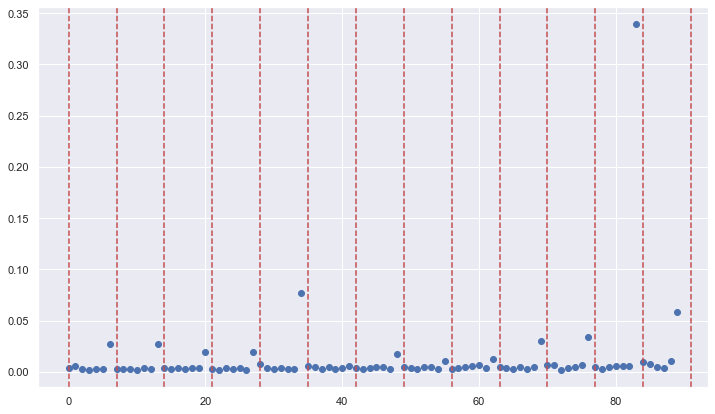

In [122]:
plt.figure(figsize = (12,7))
plt.scatter(np.arange(forest.feature_importances_.size),forest.feature_importances_)
for x in np.arange(14)*7:
    plt.axvline(x, linestyle ='--', color= 'r')
plt.show()

En este último gráfico se observa la importancia que el modelo le da a los días dentro de un periodo de 3 meses. Resalta la importancia dada cada 7 días, siendo más importante lo que ocurre en la semana 12.

In [123]:
y_pred_forest = forest.predict(X)
y_train_pred_forest = forest.predict(X_train)
y_test_pred_forest = forest.predict(X_test)

In [124]:
y_test_pred_forest.shape

(181,)

In [125]:
y_train_pred_forest.shape

(823,)

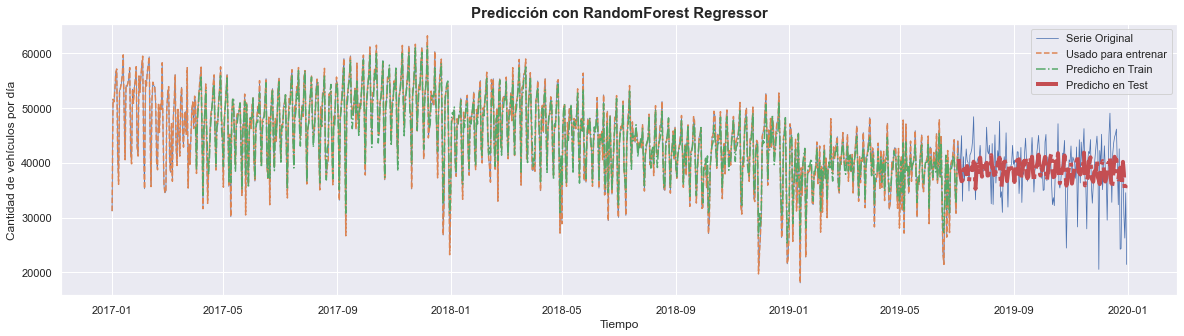

In [126]:
plt.figure(figsize=(20,5))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[:N_train + look_back], diario[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.index[look_back: look_back + N_train], y_train_pred_forest,'-.',label = 'Predicho en Train')
plt.plot(diario.index[N_train+look_back: length_total-1], y_test_pred_forest,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.title("Predicción con RandomForest Regressor", fontsize=15, fontweight='bold', fontstretch='normal')
plt.show()

In [127]:
rmse_train_forest =  np.sqrt(mean_squared_error(y_train, y_train_pred_forest))
print(f'RMSE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: {round(rmse_train_forest,2)}')

MAPE_train_forest = mean_absolute_percentage_error(y_train, y_train_pred_forest)*100
print(f'MAPE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: {round(MAPE_train_forest,2)} %')

RMSE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: 1814.24
MAPE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: 3.35 %


In [128]:
rmse_test_forest =  np.sqrt(mean_squared_error(y_test, y_test_pred_forest))
print(f'RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: {round(rmse_test_forest,2)}')

MAPE_test_forest = mean_absolute_percentage_error(y_test, y_test_pred_forest)*100
print(f'MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: {round(MAPE_test_forest,2)} %')

RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: 4219.53
MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: 8.78 %


##### 3.4.2 Random Forest Regressor + Multi-Step Prediction

Con el modelo ya entrenado, vamos a usar el método recursivo para hacer Multi-Step prediction.

In [129]:
y_ms_test_pred_rf = []
x = X_test[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test.size):
    y_os_pred_rf = forest.predict(x.reshape(1,-1))
    y_ms_test_pred_rf.append(y_os_pred_rf)
    x = np.append(x[1:], y_os_pred_rf)
y_ms_test_pred_rf = np.array(y_ms_test_pred_rf)

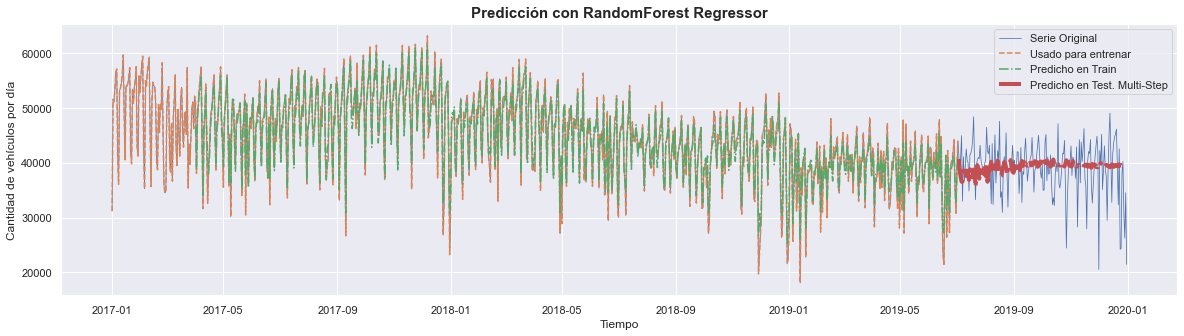

In [130]:
plt.figure(figsize=(20,5))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[:N_train + look_back], diario[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.index[look_back: look_back + N_train], y_train_pred_forest,'-.',label = 'Predicho en Train')
plt.plot(diario.index[N_train+look_back: length_total-1], y_ms_test_pred_rf,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.title("Predicción con RandomForest Regressor", fontsize=15, fontweight='bold', fontstretch='normal')
plt.show()

In [131]:
rmse_test_ms_rf =  np.sqrt(mean_squared_error(y_test, y_ms_test_pred_rf))
print(f'RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR MULTI-STEP PRED.: {round(rmse_test_ms_rf,2)}')

MAPE_test_ms_rf = mean_absolute_percentage_error(y_test, y_ms_test_pred_rf)*100
print(f'MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR MULTI-STEP PRED.: {round(MAPE_test_ms_rf,2)} %')

RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR MULTI-STEP PRED.: 4846.48
MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR MULTI-STEP PRED.: 10.18 %


##### 3.4.3 Metodología Prophet

In [132]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [133]:
diario

cantidad_pasos
fecha                     
2017-01-01         31183.0
2017-01-02         51568.0
2017-01-03         51093.0
2017-01-04         53332.0
2017-01-05         56486.0
...                    ...
2019-12-27         40182.0
2019-12-28         30681.0
2019-12-29         26259.0
2019-12-30         34523.0
2019-12-31         21447.0

[1095 rows x 1 columns]

In [134]:
diario_ph = diario.copy()

In [135]:
diario_ph["ds"] = diario.index
diario_ph["y"] = diario.cantidad_pasos

diario_ph.drop(["cantidad_pasos"],axis=1, inplace=True)

diario_ph.reset_index(drop=True, inplace=True)
diario_ph

ds        y
0    2017-01-01  31183.0
1    2017-01-02  51568.0
2    2017-01-03  51093.0
3    2017-01-04  53332.0
4    2017-01-05  56486.0
...         ...      ...
1090 2019-12-27  40182.0
1091 2019-12-28  30681.0
1092 2019-12-29  26259.0
1093 2019-12-30  34523.0
1094 2019-12-31  21447.0

[1095 rows x 2 columns]

In [136]:
diario_ph.loc[912]

ds    2019-07-02 00:00:00
y                 43996.0
Name: 912, dtype: object

In [137]:
train_ph = diario_ph.loc[:912,:]
test_ph = diario_ph.loc[913:,:]

In [138]:
train_ph

ds        y
0   2017-01-01  31183.0
1   2017-01-02  51568.0
2   2017-01-03  51093.0
3   2017-01-04  53332.0
4   2017-01-05  56486.0
..         ...      ...
908 2019-06-28  44179.0
909 2019-06-29  34754.0
910 2019-06-30  30793.0
911 2019-07-01  38705.0
912 2019-07-02  43996.0

[913 rows x 2 columns]

In [139]:
test_ph

ds        y
913  2019-07-03  41613.0
914  2019-07-04  37124.0
915  2019-07-05  40815.0
916  2019-07-06  44932.0
917  2019-07-07  32975.0
...         ...      ...
1090 2019-12-27  40182.0
1091 2019-12-28  30681.0
1092 2019-12-29  26259.0
1093 2019-12-30  34523.0
1094 2019-12-31  21447.0

[182 rows x 2 columns]

In [140]:
prophet = Prophet()
prophet.fit(train_ph)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [141]:
y_train_pred_ph = prophet.predict(train_ph)
y_test_pred_ph = prophet.predict(test_ph)

In [142]:
future = prophet.make_future_dataframe(periods=365)
forecast = prophet.predict(future)

In [143]:
future

ds
0    2017-01-01
1    2017-01-02
2    2017-01-03
3    2017-01-04
4    2017-01-05
...         ...
1273 2020-06-27
1274 2020-06-28
1275 2020-06-29
1276 2020-06-30
1277 2020-07-01

[1278 rows x 1 columns]

In [144]:
forecast

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0    2017-01-01  49048.323117  32606.891828  44277.326506  49048.323117   
1    2017-01-02  49047.451648  39242.794385  50960.037811  49047.451648   
2    2017-01-03  49046.580179  40465.036403  52609.070964  49046.580179   
3    2017-01-04  49045.708710  42404.936169  54135.694278  49045.708710   
4    2017-01-05  49044.837241  43024.542314  55171.435276  49044.837241   
...         ...           ...           ...           ...           ...   
1273 2020-06-27  38291.891787  26681.286910  39410.072209  35757.805477   
1274 2020-06-28  38289.337572  21867.234599  34903.250202  35743.099761   
1275 2020-06-29  38286.783357  29360.009624  42210.321585  35728.394045   
1276 2020-06-30  38284.229141  29775.420585  43436.776819  35713.909826   
1277 2020-07-01  38281.674926  32426.619088  46041.760630  35702.815877   

       trend_upper  additive_terms  additive_terms_lower  \
0     49048.323117   -10489.608069         -10489.608069   
1     49047.451648    -3866.745425          -3866.745425   
2     49046.580179    -2636.804361          -2636.804361   
3     49045.708710     -751.859104           -751.859104   
4     49044.837241      434.958026            434.958026   
...            ...             ...                   ...   
1273  40784.450733    -5245.571814          -5245.571814   
1274  40796.362270    -9877.891016          -9877.891016   
1275  40805.535154    -2957.465035          -2957.465035   
1276  40814.492613    -1451.767350          -1451.767350   
1277  40823.450072      684.437642            684.437642   

      additive_terms_upper       weekly  weekly_lower  weekly_upper  \
0            -10489.608069 -7724.747060  -7724.747060  -7724.747060   
1             -3866.745425  -980.355771   -980.355771   -980.355771   
2             -2636.804361   334.734081    334.734081    334.734081   
3              -751.859104  2268.441926   2268.441926   2268.441926   
4               434.958026  3468.223634   3468.223634   3468.223634   
...                    ...          ...           ...           ...   
1273          -5245.571814 -2933.371914  -2933.371914  -2933.371914   
1274          -9877.891016 -7724.747060  -7724.747060  -7724.747060   
1275          -2957.465035  -980.355771   -980.355771   -980.355771   
1276          -1451.767350   334.734081    334.734081    334.734081   
1277            684.437642  2268.441926   2268.441926   2268.441926   

           yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0    -2764.861010  -2764.861010  -2764.861010                   0.0   
1    -2886.389654  -2886.389654  -2886.389654                   0.0   
2    -2971.538443  -2971.538443  -2971.538443                   0.0   
3    -3020.301029  -3020.301029  -3020.301029                   0.0   
4    -3033.265608  -3033.265608  -3033.265608                   0.0   
...           ...           ...           ...                   ...   
1273 -2312.199900  -2312.199900  -2312.199900                   0.0   
1274 -2153.143956  -2153.143956  -2153.143956                   0.0   
1275 -1977.109264  -1977.109264  -1977.109264                   0.0   
1276 -1786.501431  -1786.501431  -1786.501431                   0.0   
1277 -1584.004284  -1584.004284  -1584.004284                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                            0.0                         0.0  38558.715047  
1                            0.0                         0.0  45180.706223  
2                            0.0                         0.0  46409.775817  
3                            0.0                         0.0  48293.849606  
4                            0.0                         0.0  49479.795267  
...                          ...                         ...           ...  
1273                         0.0                         0.0  33046.319974  
1274                         0.0                         0.0  28411.4

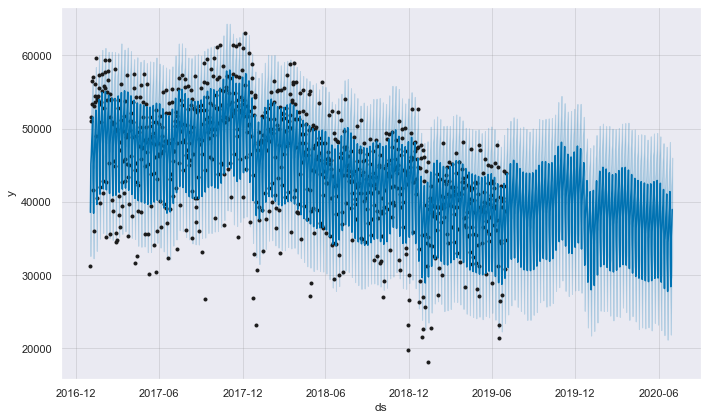

In [145]:
fig1 = prophet.plot(forecast)

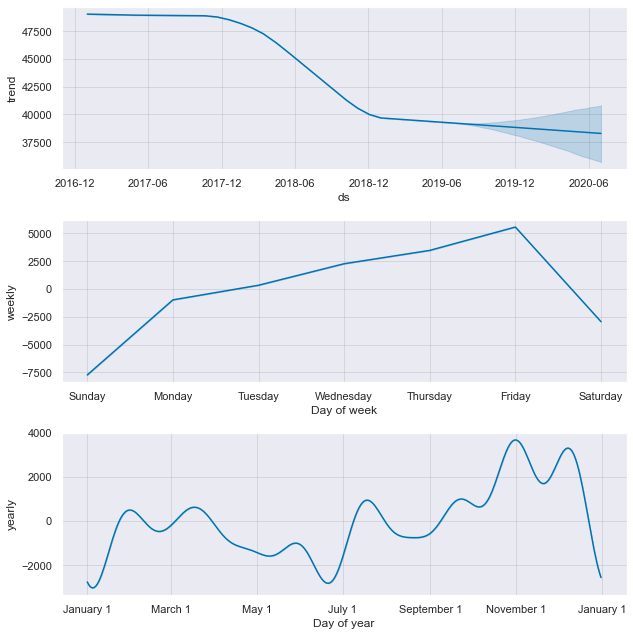

In [146]:
fig1 = prophet.plot_components(forecast)

In [147]:
y_train_ph = train_ph["y"]
y_test_ph = test_ph["y"]

In [148]:
MSE_train_ph = mean_squared_error(y_train_ph, y_train_pred_ph["yhat"])
print('RMSE EN TRAIN, PROPHET:',round(np.sqrt(MSE_train_ph),2))

MSE_test_ph = mean_squared_error(y_test_ph, y_test_pred_ph["yhat"])
print('RMSE EN TEST, PROPHET:',round(np.sqrt(MSE_test_ph),2))

MAPE_test_ph = mean_absolute_percentage_error(y_test_ph, y_test_pred_ph["yhat"])*100
print(f'MAPE EN TEST, PROPHET: {round(MAPE_test_ph,2)} %')

RMSE EN TRAIN, PROPHET: 4737.72
RMSE EN TEST, PROPHET: 5009.69
MAPE EN TEST, PROPHET: 10.08 %


##### 3.4.4 Otro Modelo de ML

Se analizan un segundo modelo de Machine Learning para observar su comportamiento frente a los datos y evaluar finalmente qué modelo predice mejor.

In [149]:
from xgboost import XGBRegressor

In [150]:
from xgboost.sklearn import XGBRegressor

In [151]:
xgb = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, objective="reg:squarederror")

In [152]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [153]:
y_pred_xgb = xgb.predict(X)
y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb = xgb.predict(X_test)

In [154]:
y_test_pred_xgb.shape

(181,)

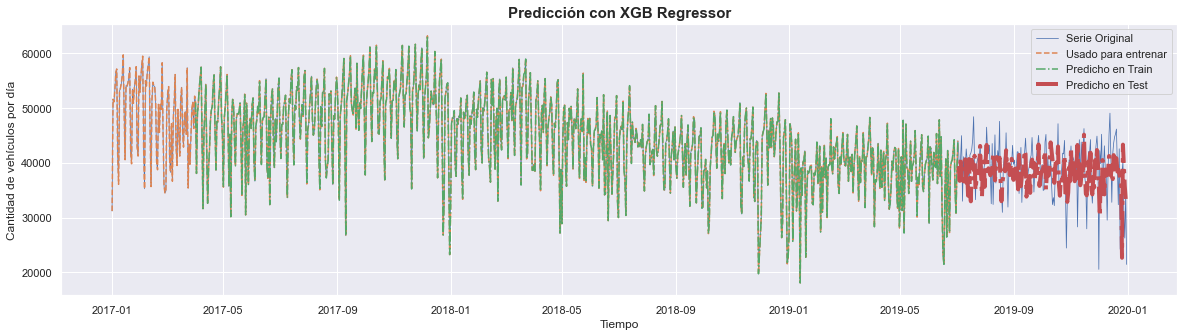

In [155]:
plt.figure(figsize=(20,5))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[:N_train + look_back], diario[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.index[look_back: look_back + N_train], y_train_pred_xgb,'-.',label = 'Predicho en Train')
plt.plot(diario.index[N_train+look_back: length_total-1], y_test_pred_xgb,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.title("Predicción con XGB Regressor", fontsize=15, fontweight='bold', fontstretch='normal')
plt.show()

In [156]:
rmse_train_xgb =  np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
print(f'RMSE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: {round(rmse_train_xgb,2)}')

MAPE_train_xgb = mean_absolute_percentage_error(y_train, y_train_pred_xgb)*100
print(f'MAPE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: {round(MAPE_train_xgb,2)} %')

print()

rmse_test_xgb =  np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
print(f'RMSE EN TEST, MODELO XGB REGRESSOR ONE-STEP PRED.: {round(rmse_test_xgb,2)}')

MAPE_test_xgb = mean_absolute_percentage_error(y_test, y_test_pred_xgb)*100
print(f'MAPE EN TEST, MODELO XGB REGRESSOR ONE-STEP PRED.: {round(MAPE_test_xgb,2)} %')

RMSE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: 12.0
MAPE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: 0.02 %

RMSE EN TEST, MODELO XGB REGRESSOR ONE-STEP PRED.: 4827.73
MAPE EN TEST, MODELO XGB REGRESSOR ONE-STEP PRED.: 9.84 %


Con el modelo entrenado, se utiliza el método Multi-Step Prediction.

In [157]:
y_ms_test_pred_xgb = []
x = X_test[0,:] # arrancamos con la primera instancia del conjunto de test
for i in range(y_test.size):
    y_os_pred_xgb = xgb.predict(x.reshape(1,-1))
    y_ms_test_pred_xgb.append(y_os_pred_xgb)
    x = np.append(x[1:], y_os_pred_xgb)
y_ms_test_pred_xgb = np.array(y_ms_test_pred_xgb)

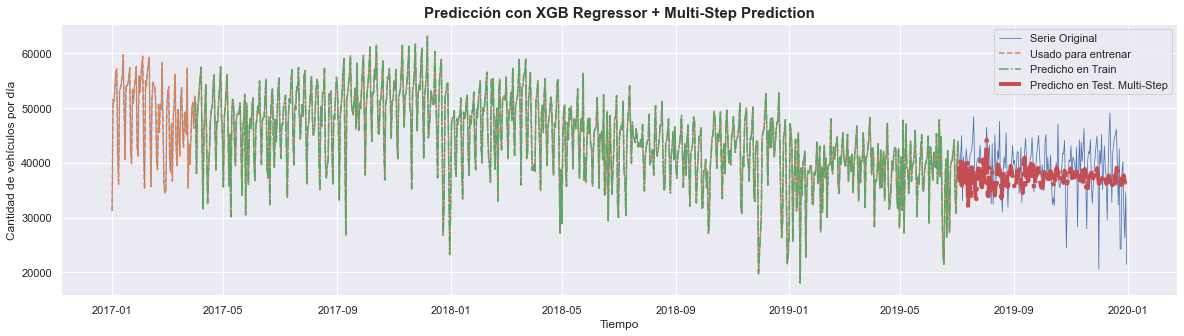

In [158]:
plt.figure(figsize=(20,5))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[:N_train + look_back], diario[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.index[look_back: look_back + N_train], y_train_pred_xgb,'-.',label = 'Predicho en Train')
plt.plot(diario.index[N_train+look_back: length_total-1], y_ms_test_pred_xgb,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.title("Predicción con XGB Regressor + Multi-Step Prediction", fontsize=15, fontweight='bold', fontstretch='normal')
plt.show()

In [159]:
rmse_test_ms_xgb =  np.sqrt(mean_squared_error(y_test, y_ms_test_pred_xgb))
print(f'RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR MULTI-STEP PRED.: {round(rmse_test_ms_xgb,2)}')

MAPE_test_ms_xgb = mean_absolute_percentage_error(y_test, y_ms_test_pred_xgb)*100
print(f'MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR-MULTI-STEP PRED.: {round(MAPE_test_ms_xgb,2)} %')

RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR MULTI-STEP PRED.: 4907.77
MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR-MULTI-STEP PRED.: 10.27 %


De los modelos utilizados en este apartado, uno usaría el método One-Step Prediction con XGB Regressor ya que arroja el menor valor en test. Sin embargo, **se define usar el método Random Forest Regressor** porque al medir el error del modelo XGB Regressor con los datos de entrenamiento se encontró un valor cercano al cero, lo cual indica un caso de overfitting en train.

In [160]:
rmse_test_benchmark =  np.sqrt(mean_squared_error(y_test, y_test_pred_benchmark))
print(f'RMSE EN TEST, MODELO BENCHMARK ONE-STEP PRED.: {round(rmse_test_benchmark,2)}')
MAPE_test_benchmark = mean_absolute_percentage_error(y_test, y_test_pred_benchmark)*100
print(f'MAPE EN TEST, MODELO BENCHMARK ONE-STEP PRED.: {round(MAPE_test_benchmark,2)} %')
print("")
rmse_test_forest =  np.sqrt(mean_squared_error(y_test, y_test_pred_forest))
print(f'RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: {round(rmse_test_forest,2)}')
MAPE_test_forest = mean_absolute_percentage_error(y_test, y_test_pred_forest)*100
print(f'MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: {round(MAPE_test_forest,2)} %')
print('')
rmse_test_ms_rf =  np.sqrt(mean_squared_error(y_test, y_ms_test_pred_rf))
print(f'RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR MULTI-STEP PRED.: {round(rmse_test_ms_rf,2)}')
MAPE_test_ms_rf = mean_absolute_percentage_error(y_test, y_ms_test_pred_rf)*100
print(f'MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR MULTI-STEP PRED.: {round(MAPE_test_ms_rf,2)} %')
print("")
MSE_test_ph = mean_squared_error(y_test_ph, y_test_pred_ph["yhat"])
print('RMSE EN TEST, PROPHET:',round(np.sqrt(MSE_test_ph),2))
MAPE_test_ph = mean_absolute_percentage_error(y_test_ph, y_test_pred_ph["yhat"])*100
print(f'MAPE EN TEST, PROPHET: {round(MAPE_test_ph,2)} %')
print("")
rmse_test_xgb =  np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
print(f'RMSE EN TEST, MODELO XGB REGRESSOR ONE-STEP PRED.: {round(rmse_test_xgb,2)}')
MAPE_test_xgb = mean_absolute_percentage_error(y_test, y_test_pred_xgb)*100
print(f'MAPE EN TEST, MODELO XGB REGRESSOR ONE-STEP PRED.: {round(MAPE_test_xgb,2)} %')
print("")
rmse_test_ms_xgb =  np.sqrt(mean_squared_error(y_test, y_ms_test_pred_xgb))
print(f'RMSE EN TEST, MODELO XGB REGRESSOR MULTI-STEP PRED.: {round(rmse_test_ms_xgb,2)}')
MAPE_test_ms_xgb = mean_absolute_percentage_error(y_test, y_ms_test_pred_xgb)*100
print(f'MAPE EN TEST, MODELO XGB REGRESSOR-MULTI-STEP PRED.: {round(MAPE_test_ms_xgb,2)} %')

RMSE EN TEST, MODELO BENCHMARK ONE-STEP PRED.: 5907.95
MAPE EN TEST, MODELO BENCHMARK ONE-STEP PRED.: 12.27 %

RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: 4219.53
MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: 8.78 %

RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR MULTI-STEP PRED.: 4846.48
MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR MULTI-STEP PRED.: 10.18 %

RMSE EN TEST, PROPHET: 5009.69
MAPE EN TEST, PROPHET: 10.08 %

RMSE EN TEST, MODELO XGB REGRESSOR ONE-STEP PRED.: 4827.73
MAPE EN TEST, MODELO XGB REGRESSOR ONE-STEP PRED.: 9.84 %

RMSE EN TEST, MODELO XGB REGRESSOR MULTI-STEP PRED.: 4907.77
MAPE EN TEST, MODELO XGB REGRESSOR-MULTI-STEP PRED.: 10.27 %


Aquí se puede observar lo comentado acerca de los datos en train.

In [161]:
rmse_train_forest =  np.sqrt(mean_squared_error(y_train, y_train_pred_forest))
print(f'RMSE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: {round(rmse_train_forest,2)}')
MAPE_train_forest = mean_absolute_percentage_error(y_train, y_train_pred_forest)*100
print(f'MAPE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: {round(MAPE_train_forest,2)} %')
print()
rmse_train_xgb =  np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
print(f'RMSE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: {round(rmse_train_xgb,2)}')
MAPE_train_xgb = mean_absolute_percentage_error(y_train, y_train_pred_xgb)*100
print(f'MAPE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: {round(MAPE_train_xgb,2)} %')

RMSE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: 1814.24
MAPE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: 3.35 %

RMSE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: 12.0
MAPE EN TRAIN, MODELO XGB REGRESSOR ONE-STEP PRED.: 0.02 %


##### 3.4.5 Optimización de hiperparámetros

Para optimizar un modelo de ML generalmente se comienza con mejor selección de los datos en el conjunto train y test. Esto implica asegurar aún más la aleatoriedad de los datos. Por ende, comenzaríamos a realizar un CroosValidation. Sin embargo, esta aleatoriedad en los datos no es recomendable en series de tiempo ya que en estos casos conviene siempre tomar valores secuenciales. Es decir, deben seguir una secuencia temporal ya que el tiempo muy importante en nuestro análisis. Para solucionar esto, se utiliza el método llamado TimeSeriesSplit de Scikit-learn. 

Por otro lado, se ultilizará RandomSearch como método de optimización de hiperparámetros.

In [162]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [163]:
tuned_parameters = {'n_estimators': [500, 600, 700, 800, 1000],
              'max_features':['auto', 'sqrt'],
              'max_depth': [None, 1, 2, 3, 5, 10, 100],
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf':[1, 2, 3, 4],
              'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=10)

rf_RS = RandomizedSearchCV(RandomForestRegressor(random_state=42), tuned_parameters,
                           cv=tscv, n_jobs=-1, verbose=1, scoring='neg_root_mean_squared_error')

In [164]:
%%time
rf_RS.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Wall time: 23.8 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 1, 2, 3, 5, 10,
                                                      100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [500, 600, 700, 800,
                                                         1000]},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [165]:
rf_RS.best_score_

-5112.579187975002

In [166]:
rf_RS.best_params_

{'n_estimators': 700,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [167]:
print(rf_RS.best_estimator_)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=3, n_estimators=700, random_state=42)


In [168]:
y_train_pred_rf_RS = rf_RS.predict(X_train)
y_test_pred_rf_RS = rf_RS.predict(X_test)

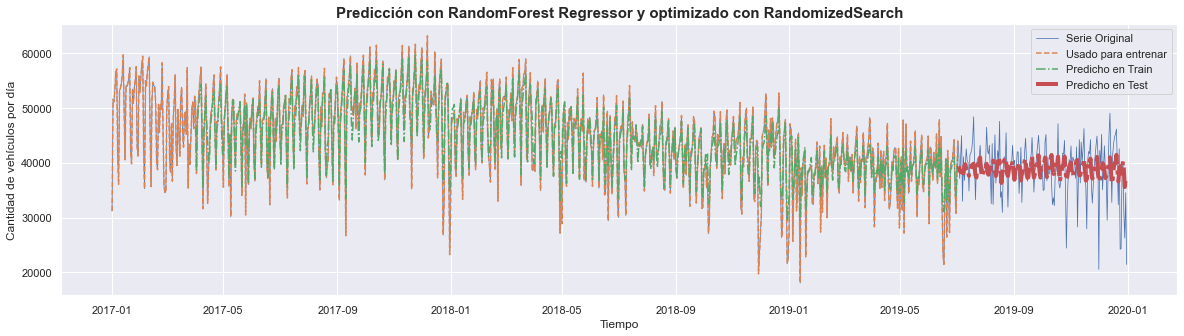

In [169]:
plt.figure(figsize=(20,5))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[:N_train + look_back], diario[:N_train + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.index[look_back: look_back + N_train], y_train_pred_rf_RS,'-.',label = 'Predicho en Train')
plt.plot(diario.index[N_train+look_back: length_total-1], y_test_pred_rf_RS,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.title("Predicción con RandomForest Regressor y optimizado con RandomizedSearch", fontsize=15, fontweight='bold', fontstretch='normal')
plt.show()

In [170]:
rmse_train_rf_RS =  np.sqrt(mean_squared_error(y_train, y_train_pred_rf_RS))
print(f'RMSE EN TRAIN, MODELO RANDOMFOREST REGRESSOR OPTIMIZADO ONE-STEP PRED.: {round(rmse_train_rf_RS,2)}')

MAPE_train_rf_RS = mean_absolute_percentage_error(y_train, y_train_pred_rf_RS)*100
print(f'MAPE EN TRAIN, MODELO RANDOMFOREST REGRESSOR OPTIMIZADO ONE-STEP PRED.: {round(MAPE_train_rf_RS,2)} %')

RMSE EN TRAIN, MODELO RANDOMFOREST REGRESSOR OPTIMIZADO ONE-STEP PRED.: 2628.24
MAPE EN TRAIN, MODELO RANDOMFOREST REGRESSOR OPTIMIZADO ONE-STEP PRED.: 4.63 %


In [171]:
rmse_test_rf_RS =  np.sqrt(mean_squared_error(y_test, y_test_pred_rf_RS))
print(f'RMSE EN TEST, MODELO RANDOMFOREST REGRESSOR OPTIMIZADO ONE-STEP PRED.: {round(rmse_test_rf_RS,2)}')

MAPE_test_rf_RS = mean_absolute_percentage_error(y_test, y_test_pred_rf_RS)*100
print(f'MAPE EN TEST, MODELO RANDOMFOREST REGRESSOR OPTIMIZADO ONE-STEP PRED.: {round(MAPE_test_rf_RS,2)} %')

RMSE EN TEST, MODELO RANDOMFOREST REGRESSOR OPTIMIZADO ONE-STEP PRED.: 4243.99
MAPE EN TEST, MODELO RANDOMFOREST REGRESSOR OPTIMIZADO ONE-STEP PRED.: 8.78 %


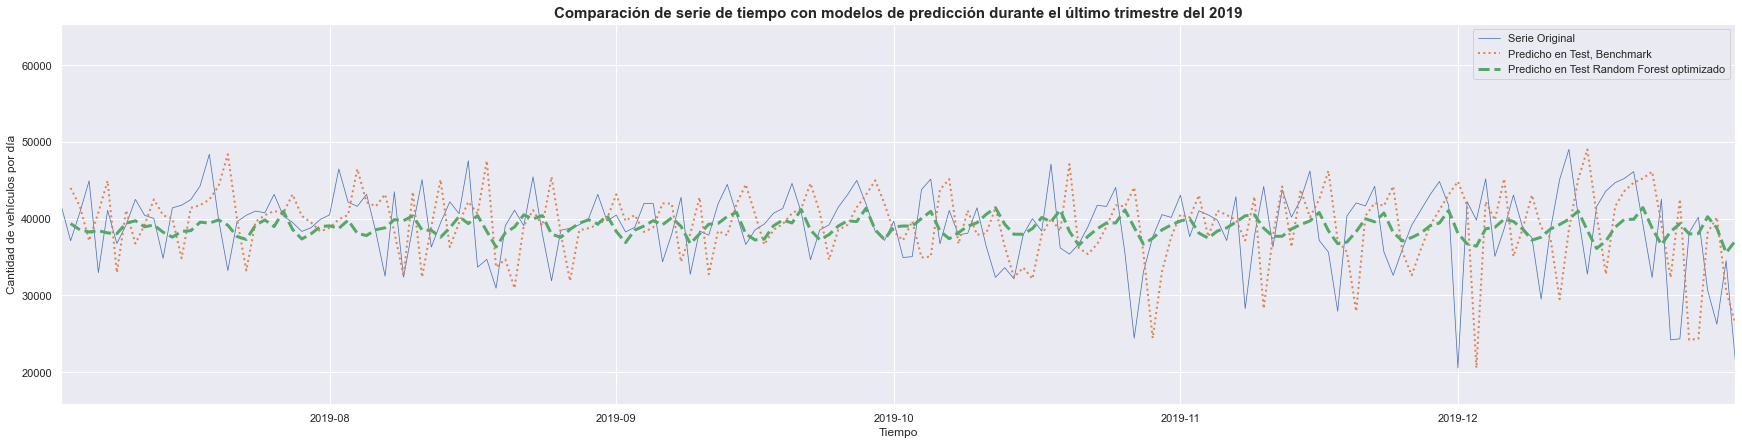

In [172]:
plt.figure(figsize=(30,7))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[N_train+look_back+1: length_total], y_test_pred_benchmark,':', lw = 2, label = 'Predicho en Test, Benchmark')
plt.plot(diario.index[N_train+look_back+1: length_total], y_test_pred_rf_RS,'--', lw = 3, label = 'Predicho en Test Random Forest optimizado')
plt.xlim(diario.index[N_train+look_back], diario.index[length_total-1])
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.title("Comparación de serie de tiempo con modelos de predicción durante el último trimestre del 2019", fontsize=15, fontweight='bold', fontstretch='normal')
plt.legend()
plt.show()

Con los valores de RMSE podemos destacar que la optimización no mejoró  la predicción. Se mantuvo prácticamente igual.

In [173]:
rmse_test_forest =  np.sqrt(mean_squared_error(y_test, y_test_pred_forest))
print(f'RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: {round(rmse_test_forest,2)}')
MAPE_test_forest = mean_absolute_percentage_error(y_test, y_test_pred_forest)*100
print(f'MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: {round(MAPE_test_forest,2)} %')
print("")
rmse_test_rf_RS =  np.sqrt(mean_squared_error(y_test, y_test_pred_rf_RS))
print(f'RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: {round(rmse_test_rf_RS,2)}')
MAPE_test_rf_RS = mean_absolute_percentage_error(y_test, y_test_pred_rf_RS)*100
print(f'MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: {round(MAPE_test_rf_RS,2)} %')

RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: 4219.53
MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: 8.78 %

RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: 4243.99
MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: 8.78 %


**Por otro lado, si comparamos el modelo RandomForest Regressor optimizado con el modelo Benchmark podemos observar que la mejora es grande. Pasamos de 5907 a 4224, siendo esto una reducción del error del 29%.**

In [174]:
rmse_test_benchmark =  np.sqrt(mean_squared_error(y_test, y_test_pred_benchmark))
print(f'RMSE EN TEST, MODELO BENCHMARK ONE-STEP PRED.: {round(rmse_test_benchmark,2)}')
MAPE_test_benchmark = mean_absolute_percentage_error(y_test, y_test_pred_benchmark)*100
print(f'MAPE EN TEST, MODELO BENCHMARK ONE-STEP PRED.: {round(MAPE_test_benchmark,2)} %')
print("")
rmse_test_rf_RS =  np.sqrt(mean_squared_error(y_test, y_test_pred_rf_RS))
print(f'RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: {round(rmse_test_rf_RS,2)}')
MAPE_test_rf_RS = mean_absolute_percentage_error(y_test, y_test_pred_rf_RS)*100
print(f'MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: {round(MAPE_test_rf_RS,2)} %')

RMSE EN TEST, MODELO BENCHMARK ONE-STEP PRED.: 5907.95
MAPE EN TEST, MODELO BENCHMARK ONE-STEP PRED.: 12.27 %

RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: 4243.99
MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: 8.78 %


#### 3.5 ¿Qué información está usando el modelo para predecir?

El modelo está utilizando 90 días de look back para predecir el valor siguiente a través del método de regresión que plantea el modelo RandomForest Regressor. Para esto toma divide el dataset en 10 segmentos. Usa el primer segmento para entrenar el modelo con los hiperparámetros mejor considerado a través de la optimización con Random Search, y el segundo segmento para testearlo. Luego, usa los 2 primeros segmentos para entrenar el modelo de la misma forma y usa el tercer segmento para testear, y así sucesivmente hasya utilizar los 10 segmentos.

Los hiperparámetros optimizados para el modelo de RandomForest Regressor son los siguientes:

In [175]:
rf_RS.best_params_

{'n_estimators': 700,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [176]:
print(rf_RS.best_estimator_)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=3, n_estimators=700, random_state=42)


Por lo tanto, **el modelo de predicción utilizado es el siguiente**:

In [177]:
tuned_parameters= {'n_estimators': [700], 'min_samples_split': [2], 'min_samples_leaf': [1], 'max_features': ['auto'], 'max_depth': [100], 'bootstrap': [True]}


rf_RS_optimized = RandomForestRegressor(n_estimators=700, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', max_depth=100, bootstrap=False,
                                        random_state=42, n_jobs=-1)

#### 3.6 Aplicación del modelo para predecir el tráfico en el año 2020. ¿Cómo funciona?

In [178]:
# Generamos una serie con datos vacíos para todo el año 2020
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2020, 12, 31)
index = pd.date_range(start, end)

pred_2020=pd.Series(np.zeros(366))
pred_2020.index=index
pred_2020

2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    0.0
             ... 
2020-12-27    0.0
2020-12-28    0.0
2020-12-29    0.0
2020-12-30    0.0
2020-12-31    0.0
Freq: D, Length: 366, dtype: float64

In [179]:
senial = diario.cantidad_pasos
senial

fecha
2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
               ...   
2019-12-27    40182.0
2019-12-28    30681.0
2019-12-29    26259.0
2019-12-30    34523.0
2019-12-31    21447.0
Freq: D, Name: cantidad_pasos, Length: 1095, dtype: float64

In [180]:
Prediccion2020 = senial.append(pred_2020)
Prediccion2020

2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
               ...   
2020-12-27        0.0
2020-12-28        0.0
2020-12-29        0.0
2020-12-30        0.0
2020-12-31        0.0
Freq: D, Length: 1461, dtype: float64

In [181]:
look_back2020=90 #Vamos a usar un año de datos anteriores para predecir
N2020=Prediccion2020.shape[0] #El total de N que tendremos será la serie que acabamos de crear.
N2020

1461

In [182]:
# Definimos X e Y

X2020 = np.zeros((N2020 - look_back2020 - 1,look_back2020)) 
y2020 = np.zeros(N2020 - look_back2020 - 1)
print(X2020.shape, y2020.shape)

(1370, 90) (1370,)


In [183]:
X2020

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [184]:
# LLenamos los X e y
for i in range(X2020.shape[0]): # en este caso, son 1370 valores que se van pronosticar.
    X2020[i,:] = Prediccion2020.iloc[i:i+look_back2020]
    y2020[i] = Prediccion2020.iloc[i+look_back2020]

In [185]:
X2020

array([[31183., 51568., 51093., ..., 51074., 46235., 52127.],
       [51568., 51093., 53332., ..., 46235., 52127., 50995.],
       [51093., 53332., 56486., ..., 52127., 50995., 38045.],
       ...,
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]])

In [186]:
X2020.shape

(1370, 90)

In [187]:
 y2020

array([50995., 38045., 48833., ...,     0.,     0.,     0.])

In [188]:
y2020.shape

(1370,)

In [189]:
N_train2020=len(diario)-look_back2020 #Para entrenar vamos a utilizar los 3 años completos de datos
N_train2020

1005

In [190]:
N_test2020 = len(pred_2020)
N_test2020

366

In [191]:
N_total2020 = N_train2020 + N_test2020
N_total2020

1371

In [192]:
length_total2020 = N_train2020 + N_test2020 + look_back2020
length_total2020

1461

In [193]:
# Hacemos el train/test split.
X_train2020 = X2020[:N_train2020,:]
y_train2020 = y2020[:N_train2020]
print(X_train2020.shape, y_train2020.shape)

X_test2020 = X2020[N_train2020:N_train2020+N_test2020,:]
y_test2020 = y2020[N_train2020:N_train2020+N_test2020]
print(X_test2020.shape, y_test2020.shape)

(1005, 90) (1005,)
(365, 90) (365,)


In [194]:
y_test2020.size

365

In [195]:
rf_RS_optimized.fit(X_train2020, y_train2020)

RandomForestRegressor(bootstrap=False, max_depth=100, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=3, n_estimators=700,
                      n_jobs=-1, random_state=42)

In [196]:
y_train_pred_2020 = rf_RS_optimized.predict(X_train2020)
y_train_pred_2020.shape

(1005,)

In [197]:
y_ms_test_pred2020 = []
x2020 = X_test2020[0,:] 
for i in range(y_test2020.size):
    y_os_pred2020 = rf_RS_optimized.predict(x2020.reshape(1,-1))
    y_ms_test_pred2020.append(y_os_pred2020)
    x2020 = np.append(x2020[1:], y_os_pred2020)
y_ms_test_pred2020 = np.array(y_ms_test_pred2020)

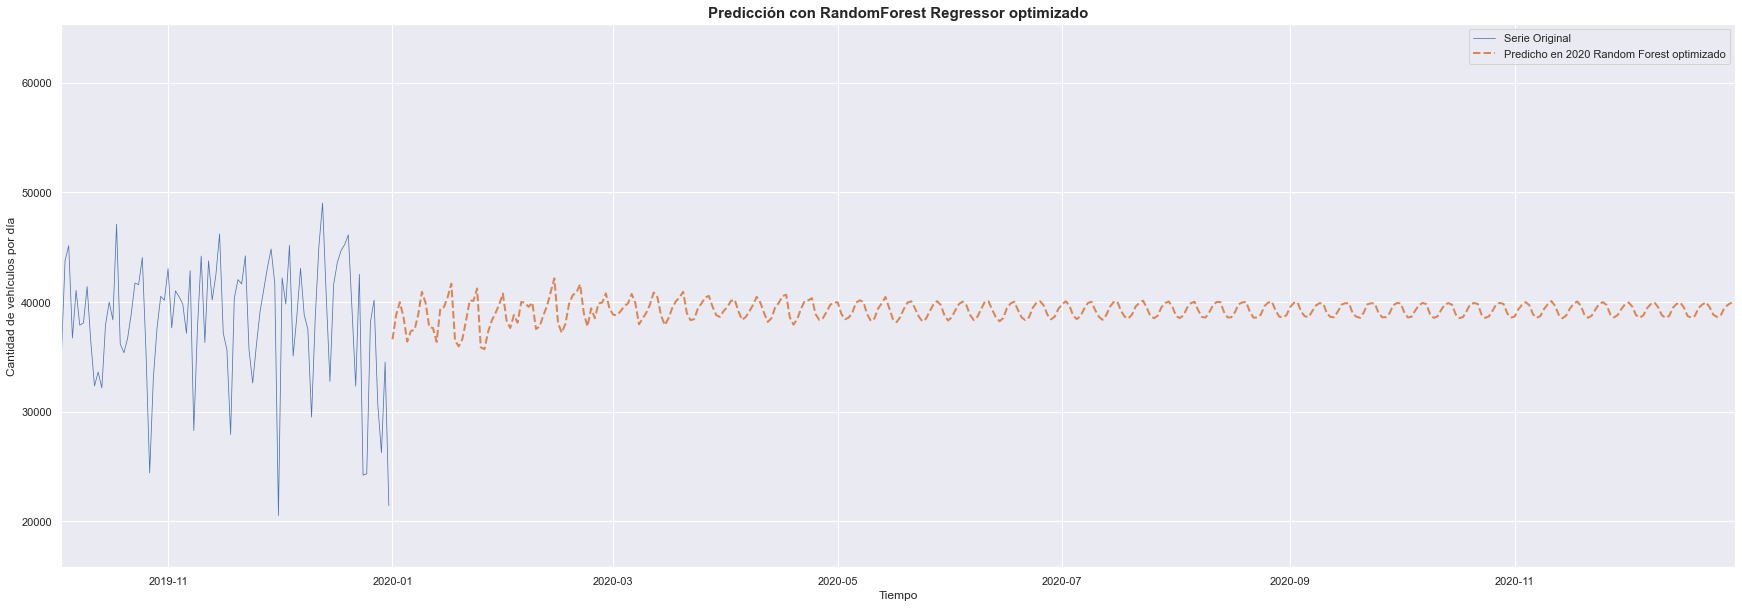

In [198]:
plt.figure(figsize=(30,10))
plt.plot(Prediccion2020.index[:N_train2020+look_back2020], Prediccion2020[:N_train2020+look_back2020],lw = 0.75, label = 'Serie Original')
#plt.plot(Prediccion2020.index[:N_train2020 + look_back2020], diario[:N_train2020 + length_total2020],'--', label = 'Usado para entrenar')
plt.plot(Prediccion2020.index[N_train2020+look_back2020: length_total2020-1], y_ms_test_pred2020,'--', lw = 2, label = 'Predicho en 2020 Random Forest optimizado')
plt.xlim(Prediccion2020.index[N_train2020], Prediccion2020.index[length_total2020-1])
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de vehículos por día')
plt.title("Predicción con RandomForest Regressor optimizado", fontsize=15, fontweight='bold', fontstretch='normal')
plt.show()

Dado que el modelo considera 90 días para predecir los valores siguientes, solamente pronostica lo que va a ocurrir durante el primer trimestre del 2020. Luego tiende hacia algún valor porque empieza a considerar valores que fueron predichos anteriormente. Por lo cual, se pierde noción de la predicción.

Si utilizamos Prophet, un modelo que es más amigable para pronosticar hacia adelante sucede lo siguiente.

In [199]:
future_2020 = prophet.make_future_dataframe(periods=548)
forecast_2020 = prophet.predict(future_2020)

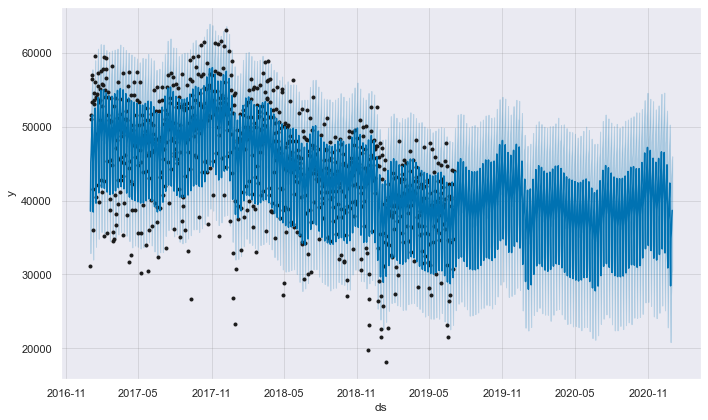

In [200]:
fig2 = prophet.plot(forecast_2020)

Es claro que este gráfico no refleja el caso real, sabiendo que en marzo del 2020 comienza la pandemia de Covid-19 que alteró enormemente la circulación de vehículos.

## 4. Conclusiones

Desde mi punto de vista, la realización de modelos de Machine Learning para predicción de series de tiempo fue algo muy útil. Sin embargo, me sucedió que si el modelo tiene retricciones muy limitadas, como el "look-back" para predecir los datos a futuro, no puede pronosticar valores más allá de esa cantidad de datos que el modelo ML que observa hacia atrás. Se tendría que ampliar el "look-back" o resamplear a valores medios semanales o mensuales apra extender esa ventana de pronóstico. Aún así el error podría ser grande, ya que el método que se necesita utilizar, Multi-Step Predition recursivo, se aleja mucho de los datos medidos y produce mucho error.

Por lo tanto, considero que la librería mayormente utilizada durante el curso, Scikit-Learn, no es lo suficientemente práctica para realizar pronósticos sobre situaciones futuras a través de los modelos ML creados con esta misma herramienta. En otras palabras, si usamos Scikit-Learn, no podemos hacer pronósticos de varios pasos adelante, ya que estamos haciendo pronósticos de un solo paso adelante cada vez que usamos los datos más recientes.

Se ha investigado un poco el tema y se han encontrado otras herramientas que intentan combinar los modelos creados con Scikit-Learn junto con otras herrameintas que ayuden a pronosticar. Entre ellas se encontró Sktime, una nueva biblioteca de Python compatible con Scikit-Learn de código abierto que proporciona una interfaz unificada para el aprendizaje automático con tareas relacionadas con series de tiempo. Permite aplicar cualquier regresor de Scikit-Learn para resolver el problema de pronóstico.

Se deja el hipervinculo para mayor información: https://github.com/alan-turing-institute/sktime.

Otra herramienta encontrada es skforecast, la cual es una biblioteca de Python que facilita el uso de regresores de scikit-learn como pronosticadores de varios pasos. Aquí se puede obterner mas detalle: https://github.com/JoaquinAmatRodrigo/skforecast.

Este proyecto es subido a GitHub: https://github.com/Maxi-FernandezG/Proyectos-DS-Acamica

## PARTE C - Investigación

## 5. Para pensar, investigar y, opcionalmente, implementar

**1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?**

La manera más práctica de agregar esta información es generando variables dummies para cada variable categórica, las cuales pueden agregar información predictiva al modelo. Sin embargo, considero que sería más eficiente considerando aquellas variables categóricas que me den información del futuro. Un ejemplo de ello, serían las fechas festivas ya que le daríamos menos peso a estas fechas a lo largo del tiempo.

**2. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?**

Lo más probable es que se comporten diferente en algún periodo de tiempo por la ampliación o creación de algún acceso a CABA, o algún desvío que agilice la circulación de vehículos y que haga aumentan o disminuir la tendencia de la circulación.

**3. ¿Hay algo que te gustaría investigar o probar?**

Me gustaría investigar y probar algún modelo que facilite el pronóstico de valores futuros, tales como ARIMA o SARIMAX. Estos modelos son propios de series de tiempo. Por esta raón me gustaría aplicarlo. Para eso voy a determinar los parámetros necesarios para un modelo de este tipo, voy a utilizar la librería statsmodels y voy a comparar esta predicción hecha a partir del 01/01/2020 con la realizada con Multi-Step Prediction.

**3.1 Modelo SARIMAX**

probaré SARIMAX, el cual es un modelo de pronóstico de valores futuros para series de tiempo. Se basa en un modelo ARIMA que significa AutoRegressive Integrated Moving Average.Deriva de otros 3 modelos, AR (Autoregresivo), I(Integrado) y MA (Medias Móviles). Se usa cunaod la serie de tiempo tiene un comportamiento no estacionario, es decir, con tendencia no nula. Es po eso que usa un preprocesamiento de diferenciación para hacer que la serie sea estacionaria, llamado integración (I). A esto se le suma la consideración de la estacionalidad en las series. Por último, se considera variables de predicción exógenas. Esto significa que se toman en cuenta variables que están formadas por factores externos al modelo o relación entre el tiempo y la variable de interés.

El modelo ARIMA está compuesto por 3 parámetros que tienen en cuenta la estacionalidad, la tendencia y el ruido en los conjuntos de datos. Estos son 3 números enteros distintos: p, d y q. Los modelos ARIMA se denotan con la notación ARIMA (p, d, q).

* p es la parte auto-regresiva del modelo. Nos permite incorporar el efecto de valores pasados.

* d es la parte integrada del modelo. Esto incluye términos en el modelo que incorporan la cantidad de diferenciación (es decir, el número de puntos de tiempo pasado para restar del valor actual) para aplicar a la serie de tiempo. Intuitivamente, sería similar a afirmar que es probable que mañana tenga la misma temperatura si la diferencia de temperatura en los últimos tres días ha sido muy pequeña.

* q es la parte media móvil del modelo. Esto nos permite establecer el error de nuestro modelo como una combinación lineal de los valores de error observados en puntos de tiempo anteriores en el pasado.

Se toma información del siguiente link: https://medium.com/analytics-vidhya/time-series-analysis-with-sarima-model-26ed620bbc0f. Por otro lado, para definir un procedimiento para utilizar el modelo en nuestros datos, se siguió la metodología doptada en este artículo: https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

Aplicando el modelo SARIMAX, se espera obtener una predicción para el primer semestre del año 2020 con una tendencia descendente gradual. De esta manera respetaría la tendencia obtenida al descomponer la serie de tiempo. Esto implicaría que el modelo SARIMAX predice más allá de la capacidad de predicción del modelo RandomForest Regressor con Multi-Step Prediction.

In [212]:
diario.tail()

cantidad_pasos
fecha                     
2019-12-27         40182.0
2019-12-28         30681.0
2019-12-29         26259.0
2019-12-30         34523.0
2019-12-31         21447.0

In [325]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

Se seleccionan los parametros como sigue:

* p = 7, ya que según el análisis de autorregresión se encontró que los datos toman en cuenta lo que sucede 7 días antes de la fecha del valor observado.

* d = 1. Se toma este valor como grado de diferenciación. Se probó con grado 2 pero se observó un alto valor de RMSE.

* q = 7. Se adopta el mismo valor que p.

In [332]:
sarimax_model = sm.tsa.statespace.SARIMAX(diario.cantidad_pasos,
                                order=(7, 1, 7),
                                seasonal_order=(7, 1, 7, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

In [333]:
resultado_sarimax = sarimax_model.fit()

C:\Users\SMFernandez\.conda\envs\timeseries\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [334]:
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     cantidad_pasos   No. Observations:                 1095
Model:             SARIMAX(7, 1, 7)x(7, 1, 7, 12)   Log Likelihood               -9927.179
Date:                            Wed, 28 Apr 2021   AIC                          19912.358
Time:                                    15:33:42   BIC                          20054.392
Sample:                                01-01-2017   HQIC                         19966.367
                                     - 12-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6427      0.566     -1.136      0.256      -1.751       0.466
ar.L2         -0.7693      0.167     -4.604      0.000      -1.097      -0.442
ar.L3         -0.7273      0.467     -1.557      0.119      -1.643       0.188
ar.L4         -0.6748      0.324     -2.081      0.037      -1.310      -0.039
ar.L5         -0.8077      0.266     -3.038      0.002      -1.329      -0.287
ar.L6         -0.6186      0.494     -1.252      0.211      -1.587       0.350
ar.L7          0.1643      0.110      1.488      0.137      -0.052       0.381
ma.L1         -0.1185      0.566     -0.209      0.834      -1.227       0.990
ma.L2          0.1404      0.526      0.267      0.790      -0.891       1.172
ma.L3          0.0451      0.489      0.092      0.926      -0.913       1.003
ma.L4         -0.0452      0.404     -0.112      0.911      -0.837       0.747
ma.L5          0.2229      0.405      0.550      0.582      -0.571       1.017
ma.L6         -0.0965      0.478     -0.202      0.840      -1.034       0.841
ma.L7         -0.7242      0.485     -1.492      0.136      -1.675       0.227
ar.S.L12      -1.0145      0.556     -1.824      0.068      -2.105       0.076
ar.S.L24      -0.8868      0.570     -1.556      0.120      -2.004       0.230
ar.S.L36      -0.8218      0.575     -1.430      0.153      -1.948       0.304
ar.S.L48      -0.5846      0.499     -1.171      0.242      -1.563       0.394
ar.S.L60      -0.5924      0.441     -1.344      0.179      -1.456       0.272
ar.S.L72      -0.5969      0.313     -1.908      0.056      -1.210       0.016
ar.S.L84      -0.0926      0.101     -0.913      0.361      -0.291       0.106
ma.S.L12       0.0667      0.548      0.122      0.903      -1.007       1.140
ma.S.L24      -0.0264      0.413     -0.064      0.949      -0.835       0.782
ma.S.L36      -0.0463      0.354     -0.131      0.896      -0.740       0.648
ma.S.L48      -0.2441      0.456     -0.535      0.593      -1.138       0.650
ma.S.L60       0.0830      0.323      0.257      0.797      -0.550       0.716
ma.S.L72       0.0478      0.316      0.151      0.880      -0.572       0.668
ma.S.L84      -0.4005      0.328     -1.219      0.223      -1.044       0.243
sigma2       5.31e+07    1.2e-08   4.44e+15      0.000    5.31e+07    5.31e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):               839.52
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -1.33
Prob(H) (two-sided):                  0.36   Kurtosis:                         6.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] 

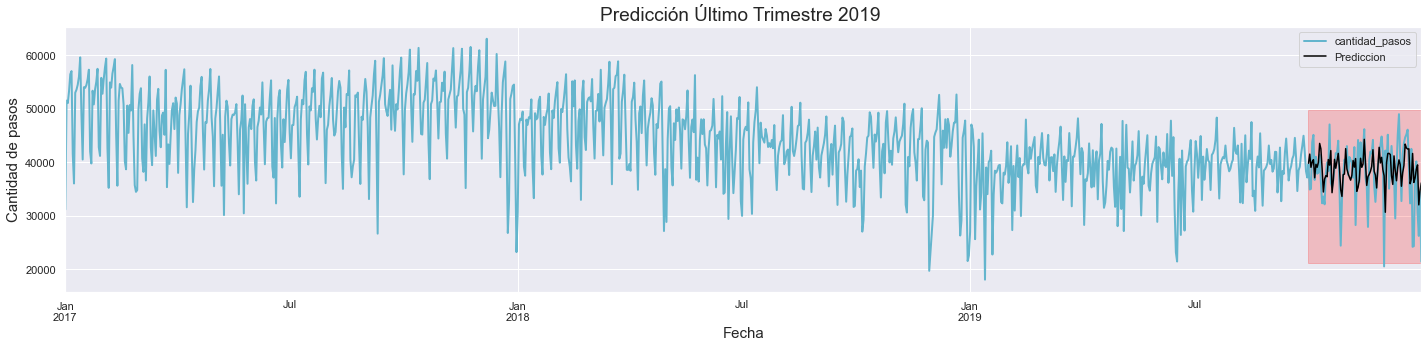

In [353]:
pred = resultado_sarimax.get_prediction(start=datetime.datetime(2019,10,1), dynamic=False)
c_pred = pred.conf_int()
ax = y['2017':].plot(label='Serie Original',color='c',lw = 2,figsize=(20,5))

pred.predicted_mean.plot(ax=ax, label='Prediccion', alpha=1, color='Black')

ax.fill_between(c_pred.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=0.2)
plt.title("Predicción Último Trimestre 2019 ", fontsize=19)
plt.xlabel('Fecha',size=15)
plt.ylabel('Cantidad de pasos', size=15)
plt.legend()
plt.tight_layout()
plt.show()

In [354]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-10-01':]

print(f'AIC PARA MODELO SARIMAX: {round(resultado_sarimax.aic,2)}')
rmse_pred =  np.sqrt(mean_squared_error(y_truth, y_forecasted))
print(f'RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: {round(rmse_pred,2)}')
MAPE_pred = mean_absolute_percentage_error(y_truth, y_forecasted)*100
print(f'MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: {round(MAPE_pred,2)} %')

AIC PARA MODELO SARIMAX: 19912.36
RMSE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: 5348.2
MAPE EN TEST, MODELO RANDOM FOREST REGRESSOR ONE-STEP PRED.: 11.83 %


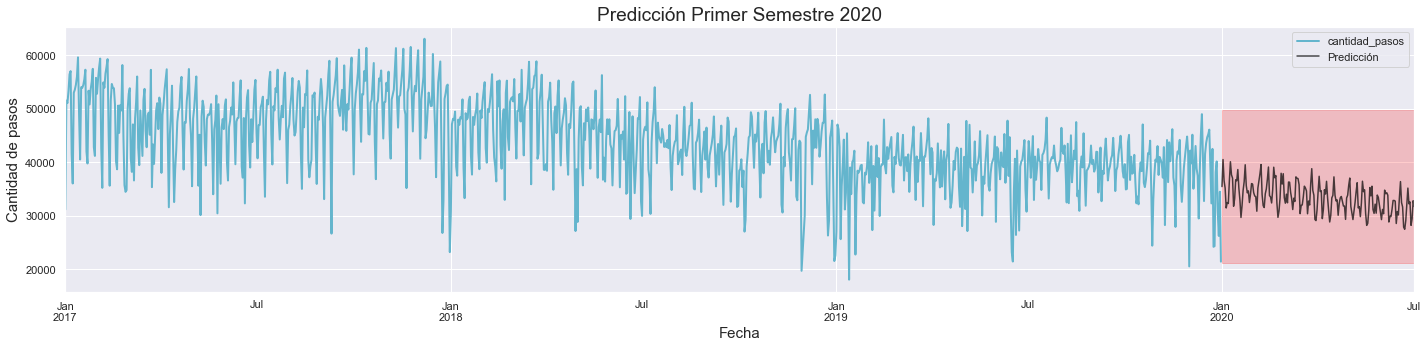

In [351]:
pred = resultado_sarimax.get_forecast(steps=datetime.datetime(2020,7,1))
c_pred = pred.conf_int()
ax = y['2017':].plot(label='Serie Original',color='c',lw = 2,figsize=(20,5))

pred.predicted_mean.plot(ax=ax, label='Predicción', alpha=0.7, color='Black')

ax.fill_between(c_pred.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='red', alpha=0.2)
plt.title("Predicción Primer Semestre 2020", fontsize=19)
plt.xlabel('Fecha',size=15)
plt.ylabel('Cantidad de pasos', size=15)
plt.legend()
plt.tight_layout()
plt.show()

Claramente, se obtuvo una mejor visualización de la predicción de la cantidad de vehículos que circularían por la Au. Illia durante el primer semestre del 2020. Sin embargo se tiene mayor error de RMSE. Se probó manualmente varias combinaciones de los parámetros p, q y d. Se tuvo como referencia el valor AIC (Criterio de información de Akaike). Básicamente, cuantifica la bondad del ajuste y la simplicidad/parsimonia del modelo. Al comparar dos modelos, el que tiene el AIC más bajo es generalmente "mejor" (https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/).

Por lo tanto, estos resultados preliminares necesitan que el modelo origen esté optimizado, algo que se verá en el proyecto 04 en caso de continuar con el análisis de series de tiempo.